# Multi-Class Logistic Regression using Kaggle ML & DS Survey Data
## Author: Yonghao Li

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import statistics
import matplotlib.pyplot as plt
import math
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, chi2
import statsmodels.api as sm
from sklearn.pipeline import Pipeline

In [ ]:
df = pd.read_csv('clean_kaggle_data_2020.csv', low_memory = False)
df.drop(df.columns[0], axis=1, inplace=True) # drop first column with finishing time
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool

In [ ]:
df.shape

(10730, 356)

## Data Cleaning

### Deal with Multiple Choice Questions

Drop columns titled "Other or "None" because they contain relatively low information in the survey.

In [ ]:
# Drop columns with "other" answers
for col in df.columns:
    # Drop "Other" columns in multiple choice questions
    if 'OTHER' in col:
        df.drop([col], axis=1, inplace=True)
    # Convert multiple choice answers into 0/1
    if 'Part' in col:
        df[col] = df[col].notnull().astype(int)

# Drop 'None' columns
df = df.loc[:, ~df.columns.str.startswith('None')]

# Drop duplicate columns
df = df.loc[:,~df.columns.duplicated()]

# Drop first row with questions
df.drop(df.index[0], inplace=True)

df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,...,Q31_B_Part_5,Q31_B_Part_6,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q24_Encoded,Q24_buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,1,1,1,0,0,0,0,0,0,0,0,0,Python,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,0,0,0,0,0,1,1,0,0,1,0,0,R,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,1,0,1,0,0,0,0,0,0,1,0,0,Python,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,1,0,1,0,0,0,0,0,0,1,0,0,Python,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0,1,0,0,0,0,0,0,0,0,0,0,R,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,"30,000-39,999"


In [ ]:
# Create function for combining the count of answers for each muultiple choice question
def mc_combined(col):
    cols = [c for c in df if c.startswith(col)]
    num_parts = len(cols)
    last_part_index = df.columns.get_loc(col + '_Part_' + str(num_parts))
    df.insert(last_part_index + 1, col + '_combined', [0] * df.shape[0], True)
    for i in range(num_parts):
        df[col + '_combined'] = df[col + '_combined'] + df[col + '_Part_'+ str(i + 1)]
    return df[col + '_combined']

Here all the "B" parts of multiple choice questions are excluded because they are about plans for the next 2 years and do not contain readily usable information, thus can be treated as irrelevant for feature selection purposes.

In [ ]:
# List of columns with multiple choice questions
mc_list = ['Q7', 'Q9', 'Q10', 'Q12', 'Q14', 'Q16', 'Q17', 'Q18', 'Q19', 'Q23', 
           'Q26_A', 'Q27_A', 'Q28_A', 'Q29_A', 'Q31_A', 'Q33_A', 'Q34_A', 'Q35_A',
           'Q36', 'Q37', 'Q39']

# Perform combination
for col in mc_list:
    mc_combined(col)

# Drop the separated multiple choice columns
for col in df.columns:
    if 'Part' in col:
        df.drop([col], axis=1, inplace=True)

In [ ]:
# Rename the combined columns
df.rename(columns={'Q7_combined': 'num_prog_lang', 'Q9_combined': 'num_IDE', 'Q10_combined': 'num_notebook', 'Q12_combined': 'num_spec_hw',
                   'Q14_combined': 'num_datavizlib', 'Q16_combined': 'num_ml_fw', 'Q17_combined': 'num_ml_algo', 'Q18_combined': 'num_CV',
                   'Q19_combined': 'num_NLP', 'Q23_combined': 'num_activity', 'Q26_A_combined': 'num_cloud_platform', 
                   'Q27_A_combined': 'num_cloud_product', 'Q28_A_combined': 'num_ml_product', 
                   'Q29_A_combined': 'num_BigData_product', 'Q31_A_combined': 'num_bi_tools', 
                   'Q33_A_combined': 'num_autoML', 'Q34_A_combined': 'num_autoML_tools',
                   'Q35_A_combined': 'num_MLexp_tools', 'Q36_combined': 'num_share_app', 'Q37_combined': 'num_course_platform', 
                   'Q39_combined': 'num_media_sources'}, inplace=True)

### Deal with NaN values

In [ ]:
# Check which columns still contain NAN values
col_with_na = df.loc[:, df.isna().any()].columns.tolist()
col_with_na

['Q8', 'Q11', 'Q13', 'Q15', 'Q25', 'Q30', 'Q32', 'Q38']

Columns with NaN values correspond to the following questions:

Q8: What programming language would you recommend an aspiring data scientist to learn first?

Q11: What type of computing platform do you use most often for your data science projects?

Q13: Approximately how many times have you used a TPU (tensor processing unit)?

Q15: For how many years have you used machine learning methods?

Q25: Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?

Q30: Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often?

Q32: Which of the following business intelligence tools do you use most often?

Q38: What is the primary tool that you use at work or school to analyze data?

It makes sense to replace Nan values with the mode (most common answer choice) in each of these columns.

In [ ]:
# Use the mode of each column to replace the NaN values
for col in col_with_na:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Make sure no NaN values left in dataframe
df.isnull().sum().sum()

0

### Deal with Other Categorical Columns

In [ ]:
# Check for remaining categorical columns
df.loc[:, df.columns.str.startswith('Q')]

,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q11,Q13,Q15,Q20,Q21,Q22,Q24,Q25,Q30,Q32,Q38,Q24_Encoded,Q24_buckets
1,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,A personal computer or laptop,2-5 times,1-2 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","100,000-124,999","$100,000 or more ($USD)",PostgresSQL,Microsoft Power BI,"Business intelligence software (Salesforce, Ta...",10.0,"100,000-124,999"
2,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,R,A personal computer or laptop,Never,I do not use machine learning methods,"1000-9,999 employees",0,No (we do not use ML methods),"15,000-19,999",$0 ($USD),MySQL,Tableau,"Basic statistical software (Microsoft Excel, G...",1.0,"10,000-19,999"
3,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,3-4 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...","125,000-149,999","$10,000-$99,999",MySQL,Tableau,"Local development environments (RStudio, Jupyt...",11.0,"125,000-149,9991"
4,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",2-5 times,2-3 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","70,000-79,999","$10,000-$99,999",Microsoft Azure Data Lake Storage,Tableau,"Cloud-based data software & APIs (AWS, GCP, Az...",7.0,"70,000-79,999"
5,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,R,A personal computer or laptop,Never,Under 1 year,0-49 employees,1-2,We use ML methods for generating insights (but...,"30,000-39,999",$1-$99,MySQL,Tableau,"Local development environments (RStudio, Jupyt...",3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,C++,A personal computer or laptop,Never,1-2 years,0-49 employees,5-9,I do not know,"2,000-2,999",$0 ($USD),MySQL,Tableau,"Basic statistical software (Microsoft Excel, G...",0.0,"0-9,999"
10726,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,Python,A personal computer or laptop,Never,I do not use machine learning methods,250-999 employees,0,No (we do not use ML methods),"15,000-19,999",$0 ($USD),Microsoft SQL Server,Microsoft Power BI,"Local development environments (RStudio, Jupyt...",1.0,"10,000-19,999"
10727,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,A personal computer or laptop,Never,I do not use machine learning methods,0-49 employees,0,We are exploring ML methods (and may one day p...,$0-999,$0 ($USD),MySQL,Tableau,"Local development environments (RStudio, Jupyt...",0.0,"0-9,999"
10728,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,"A cloud computing platform (AWS, Azure, GCP, h...",More than 25 times,1-2 years,"10,000 or more employees",20+,"We recently started using ML methods (i.e., mo...",$0-999,$0 ($USD),MySQL,Tableau,"Local development environments (RStudio, Jupyt...",0.0,"0-9,999"


In [ ]:
# Drop Q24 because we already have it encoded as target
df.drop(['Q24'], axis=1, inplace=True)

We can determine that:

Ordinal columns include Q1, Q4, Q6, Q13, Q15, Q20, Q21, Q22, Q25

Nominal columns include Q2, Q3, Q5, Q8, Q11, Q30, Q32, Q38

#### Ordinal Feature Engineering (Q1, Q4, Q6, Q13, Q15, Q20, Q21, Q22, Q25)

Q1: What is your age (# years)?

In [ ]:
Q1_label = {'18-21': 0, '22-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, 
            '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-69': 9,
            '70+': 10}
df['Age_group'] = df['Q1'].map(Q1_label)
df.drop(['Q1'], axis=1, inplace=True)

Q4: What is the highest level of formal education that you have attained or plan to attain within the next 2 years?

In [ ]:
Q4_label = {'I prefer not to answer': 0, 'No formal education past high school': 1,
            'Some college/university study without earning a bachelor’s degree': 2,
            'Professional degree': 3, 'Bachelor’s degree': 4, 'Master’s degree': 5,
            'Doctoral degree': 6}
df['Education_level'] = df['Q4'].map(Q4_label)
df.drop(['Q4'], axis=1, inplace=True)

Q6: For how many years have you been writing code and/or programming?

In [ ]:
Q6_label={'I have never written code': 0, '< 1 years': 1, '1-2 years': 2,
          '3-5 years': 3, '5-10 years': 4, '10-20 years': 5, '20+ years': 6}
df['Code_years_group'] = df['Q6'].map(Q6_label)
df.drop(['Q6'], axis=1, inplace=True)

Q13: Approximately how many times have you used a TPU (tensor processing unit)?

In [ ]:
Q13_label = {'Never': 0, 'Once': 1, '2-5 times': 2, '6-25 times': 3, 'More than 25 times': 4}
df['TPU_times_group'] = df['Q13'].map(Q13_label)
df.drop(['Q13'], axis=1, inplace=True)

Q15: For how many years have you used machine learning methods?

In [ ]:
Q15_label={'I do not use machine learning methods': 0, 'Under 1 year': 1, 
           '1-2 years': 2, '2-3 years': 3, '3-4 years': 4, '4-5 years': 5, 
           '5-10 years': 6, '10-20 years': 7, '20 or more years': 8}
df['ML_years_group'] =df['Q15'].map(Q15_label)
df.drop(['Q15'], axis=1, inplace=True)

Q20: What is the size of the company where you are employed?

In [ ]:
Q20_label={'0-49 employees': 0, '50-249 employees': 1, '250-999 employees': 2,
           '1000-9,999 employees': 3, '10,000 or more employees': 4}
df['Company_size_group'] = df['Q20'].map(Q20_label)
df.drop(['Q20'], axis=1, inplace=True)

Q21: Approximately how many individuals are responsible for data science workloads at your place of business?

In [ ]:
Q21_label={'0': 0, '1-2': 1, '3-4': 2, '5-9': 3, '10-14': 4, '15-19': 5, '20+': 6}
df['DS_employee_group'] = df['Q21'].map(Q21_label)
df.drop(['Q21'], axis=1, inplace=True)

Q22: Does your current employer incorporate machine learning methods into their business?

In [ ]:
Q22_label = {'I do not know': 0, 'No (we do not use ML methods)': 1, 
             'We are exploring ML methods (and may one day put a model into production)': 2,
             'We use ML methods for generating insights (but do not put working models into production)': 3,
             'We recently started using ML methods (i.e., models in production for less than 2 years)': 4,
             'We have well established ML methods (i.e., models in production for more than 2 years)': 5}
df['ML_business_level'] = df['Q22'].map(Q22_label)
df.drop(['Q22'], axis=1, inplace=True)

Q25: Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)?

In [ ]:
Q25_label = {'$0 ($USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3,
             '$10,000-$99,999': 4, '$100,000 or more ($USD)': 5}
df['ML_spent_level'] = df['Q25'].map(Q25_label)
df.drop(['Q25'], axis=1, inplace=True)

#### Nominal Feature Engineering (Q2, Q3, Q5, Q8, Q11, Q30, Q32, Q38)

Use one-hot encoding for categorical features that are not ordered. Target encoding might also be applicable for nominal features with high cardinality, but it could lead to overfitting since it models the prior and posterior probabilities for each unique category w.r.t. the target.

Q2: What is your gender?

In [ ]:
df = pd.get_dummies(df, columns=['Q2'], prefix='Gender_')

Q3: In which country do you currently reside?

In [ ]:
# # Encode countries based on their frequency in this survey
# labels = df['Q3'].value_counts(ascending=False).index.tolist()
# freq_codes = range(1,len(labels)+1)
# df['Q3'].replace(labels, freq_codes, inplace=True)
# df.rename(columns={'Q3': 'Country_Encoded_by_Frequency'}, inplace=True)

df = pd.get_dummies(df, columns=['Q3'], prefix='', prefix_sep='')

Q5: Select the title most similar to your current role (or most recent title if retired):

In [ ]:
# # Encode current roles based on their frequency in this survey
# labels = df['Q5'].value_counts(ascending=False).index.tolist()
# freq_codes = range(1,len(labels)+1)
# df['Q5'].replace(labels, freq_codes, inplace=True)
# df.rename(columns={'Q5': 'Roles_Encoded_by_Frequency'}, inplace=True)

df = pd.get_dummies(df, columns=['Q5'], prefix='', prefix_sep='')

Q8: What programming language would you recommend an aspiring data scientist to learn first?

In [ ]:
# # Encode recommended languages based on their frequency in this survey
# labels = df['Q8'].value_counts(ascending=False).index.tolist()
# freq_codes = range(1,len(labels)+1)
# df['Q8'].replace(labels, freq_codes, inplace=True)
# df.rename(columns={'Q8': 'Recommended_Languages_Encoded_by_Frequency'}, inplace=True)

df = pd.get_dummies(df, columns=['Q8'], prefix='RecLang_')

Q11: What type of computing platform do you use most often for your data science projects?

In [ ]:
df = pd.get_dummies(df, columns=['Q11'], prefix='Platform_')

Q30: Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often?

In [ ]:
# # Encode big data products based on their frequency in this survey
# labels = df['Q30'].value_counts(ascending=False).index.tolist()
# freq_codes = range(1,len(labels)+1)
# df['Q30'].replace(labels, freq_codes, inplace=True)
# df.rename(columns={'Q30': 'BigDataProducts_Encoded_by_Frequency'}, inplace=True)

df = pd.get_dummies(df, columns=['Q30'], prefix='BigData_')

Q32: Which of the following business intelligence tools do you use most often?

In [ ]:
# # Encode BI tools based on their frequency in this survey
# labels = df['Q32'].value_counts(ascending=False).index.tolist()
# freq_codes = range(1,len(labels)+1)
# df['Q32'].replace(labels, freq_codes, inplace=True)
# df.rename(columns={'Q32': 'BI_Tools_Encoded_by_Frequency'}, inplace=True)

df = pd.get_dummies(df, columns=['Q32'], prefix='BItools_')

Q38: What is the primary tool that you use at work or school to analyze data?

In [ ]:
df = pd.get_dummies(df, columns=['Q38'], prefix='PrimaryTool_')

In [ ]:
# Move the target columns to the end of the dataframe
cols_to_move = ['Q24_Encoded', 'Q24_buckets']
df = df[[ col for col in df.columns if col not in cols_to_move ] + cols_to_move]

In [ ]:
# Drop duplicated columns ("Other" options from nultiple choice questions)
df = df.loc[:, ~df.columns.duplicated()]

In [ ]:
df.shape

(10729, 157)

## EDA and Feature Selection

Since "Q24_Encoded" and "Q24_buckets" represent the same groups, the following parts will be mainly using "Q24_Encoded" as target labels due to its simplicity.

In [ ]:
# Save the target buckets into a new variable
salary_bucket = df['Q24_buckets']
# Use the encoded column for target
df.drop(['Q24_buckets'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


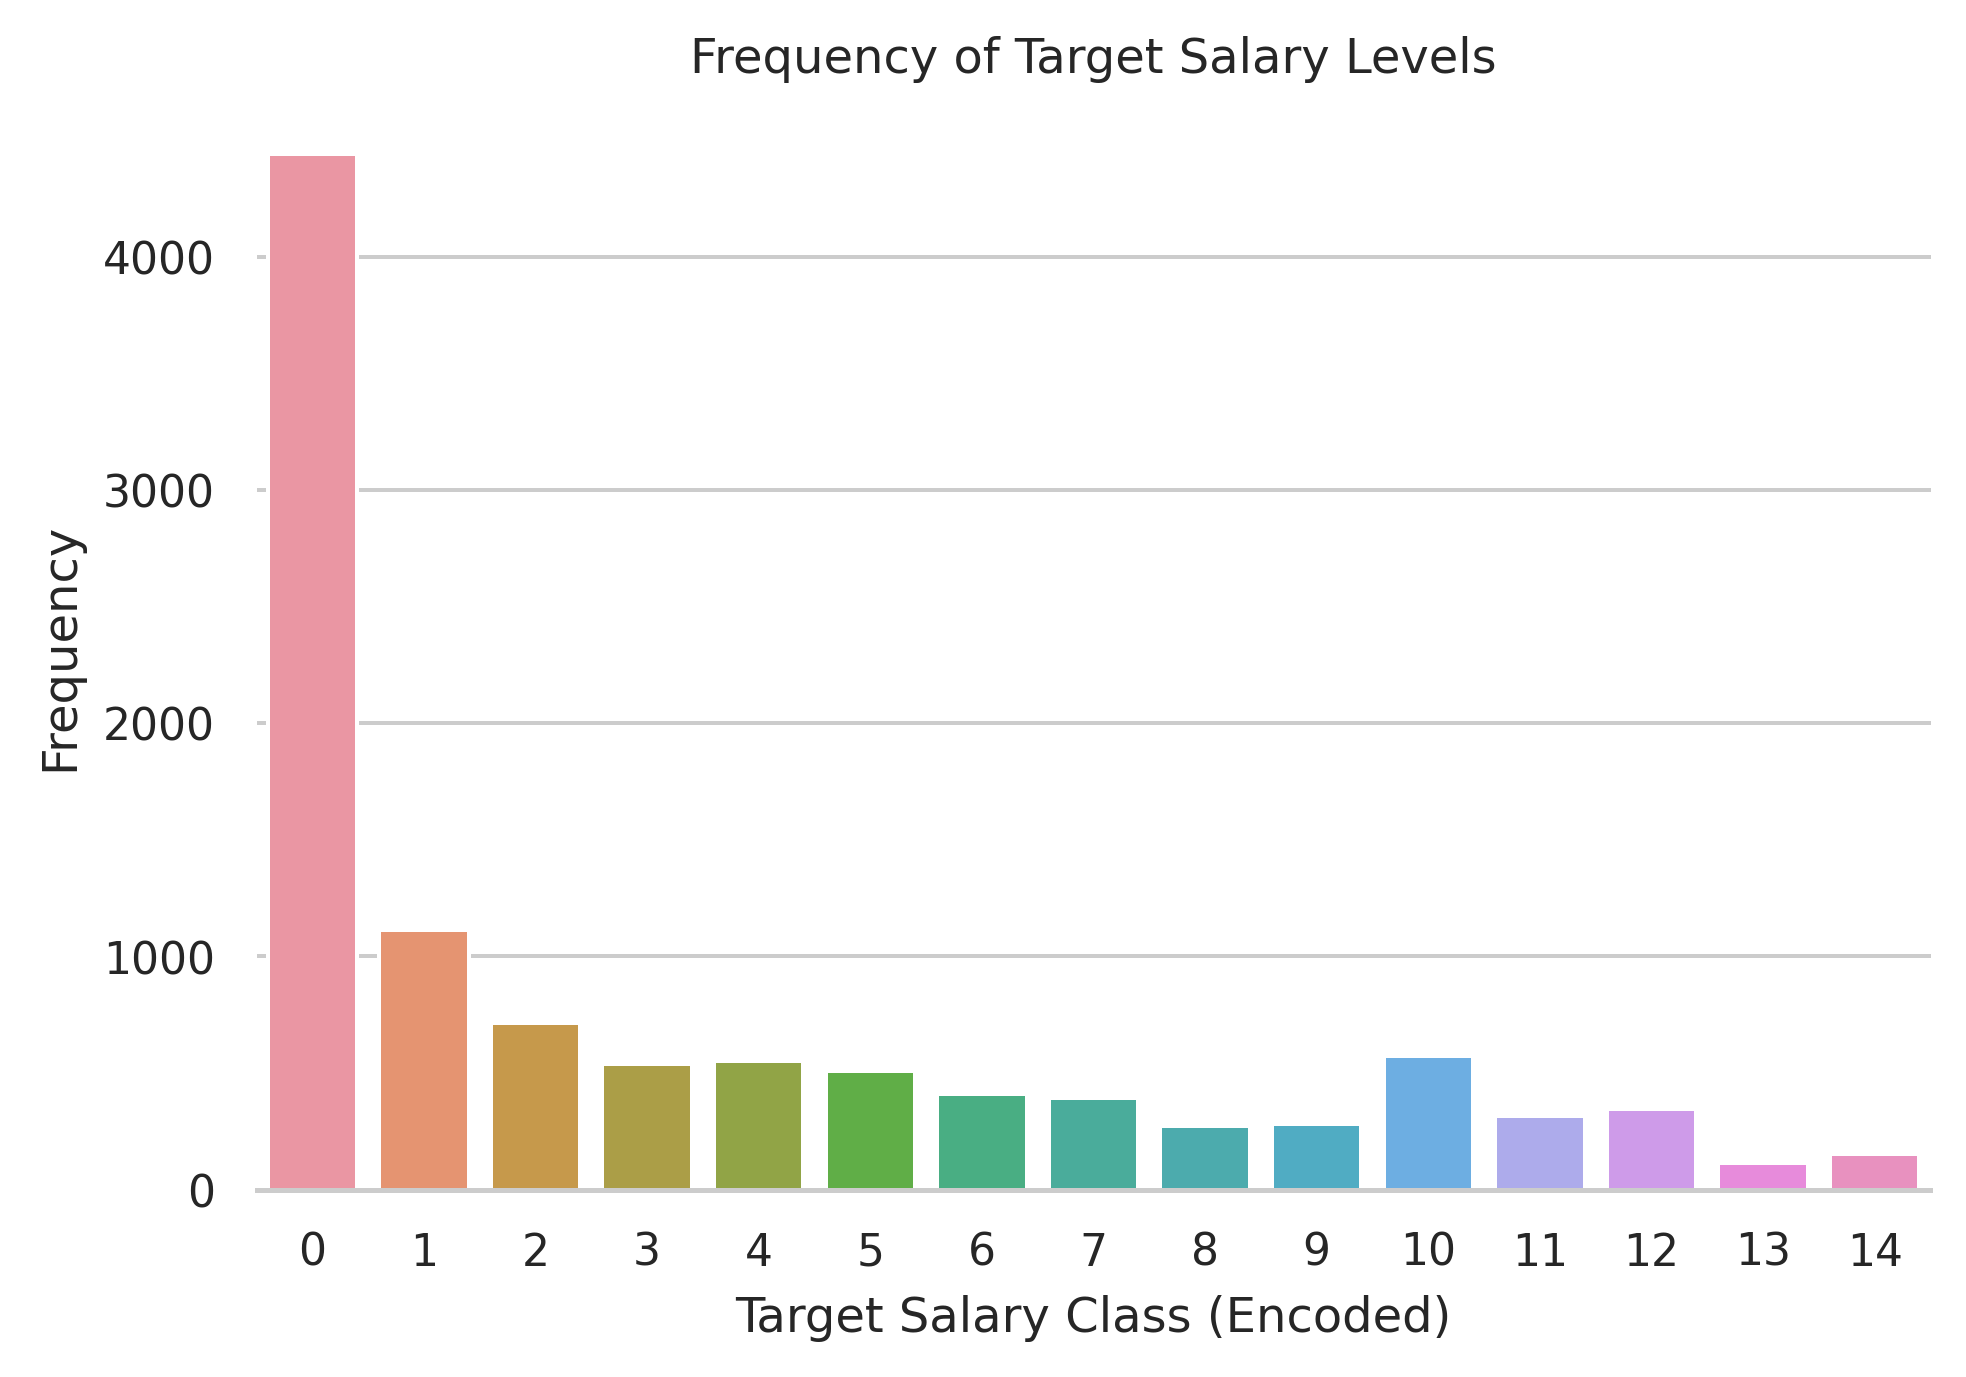

In [ ]:
# Visualization of target classes
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
index = sorted(df.Q24_Encoded.unique().astype(int))
values = df.Q24_Encoded.value_counts().sort_index()
ax = sns.barplot(index, values)
ax.set(xlabel='Target Salary Class (Encoded)', ylabel='Frequency', title='Frequency of Target Salary Levels')
sns.despine(left=True)

We can see that the first salary level (0-9,999) is the majority class in this data.

Compute the feature correlations with the encoded target:

In [ ]:
# Compute top 10 features with highest correlations to salary level
df_corr = df.corr().iloc[df.corr().shape[0] - 1, 0:-1].sort_values(ascending=False)
top_ten_corr = pd.DataFrame(df_corr.iloc[0:10])
top_ten_corr.rename(columns={'Q24_Encoded': 'Correlation Score'}, inplace=True)
top_ten_corr

,Correlation Score
United States of America,0.519362
Code_years_group,0.375758
Age_group,0.367102
ML_spent_level,0.362844
ML_years_group,0.359976
ML_business_level,0.273549
DS_employee_group,0.263443
Company_size_group,0.234390
num_activity,0.206508
num_cloud_product,0.172053


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

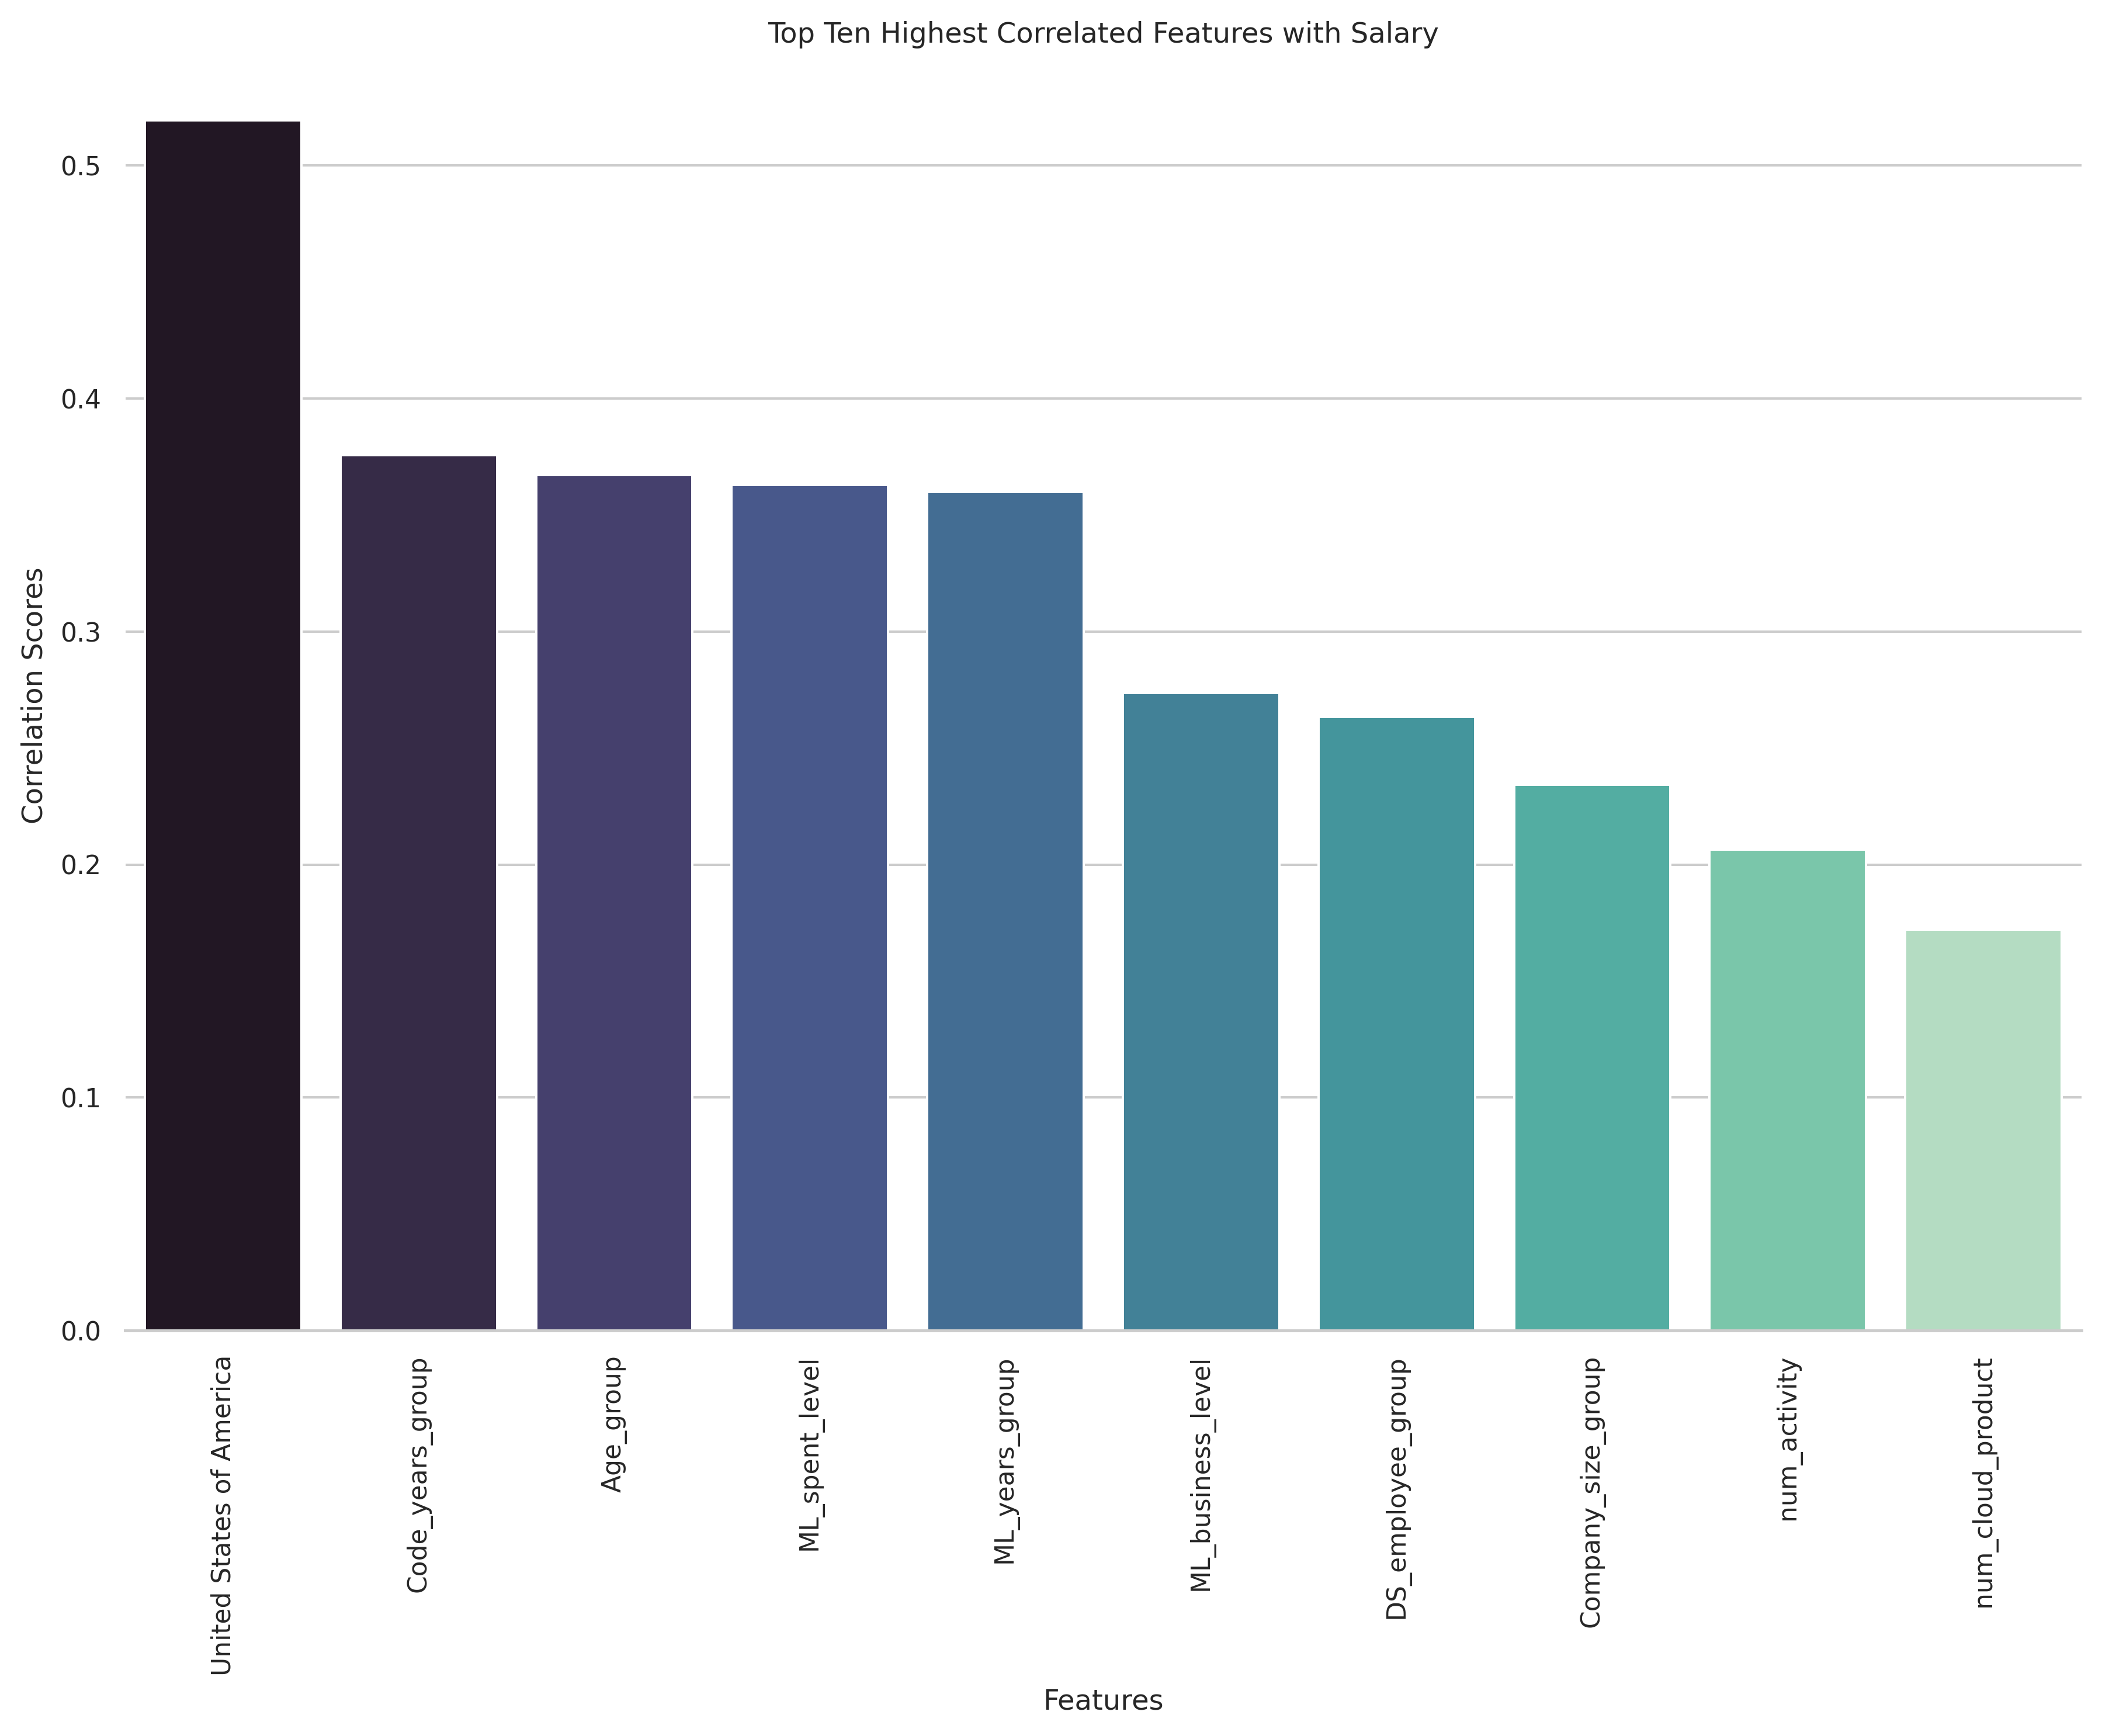

In [ ]:
# Plot the ten features
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax = sns.barplot(top_ten_corr.index, top_ten_corr['Correlation Score'], palette="mako")
ax.set(xlabel='Features', ylabel='Correlation Scores', 
       title='Top Ten Highest Correlated Features with Salary')
sns.despine(left=True)
plt.xticks(rotation='vertical')

As we can see from the correlation table and the barplot, the following features are among the most correlated with salary levels:
- Whether the participant works in USA;
- Years of coding experience;
- Age;
- Amount of money spent on machine learning services;
- Years of using machine learning methods.

### Visualizations of the Correlated Features

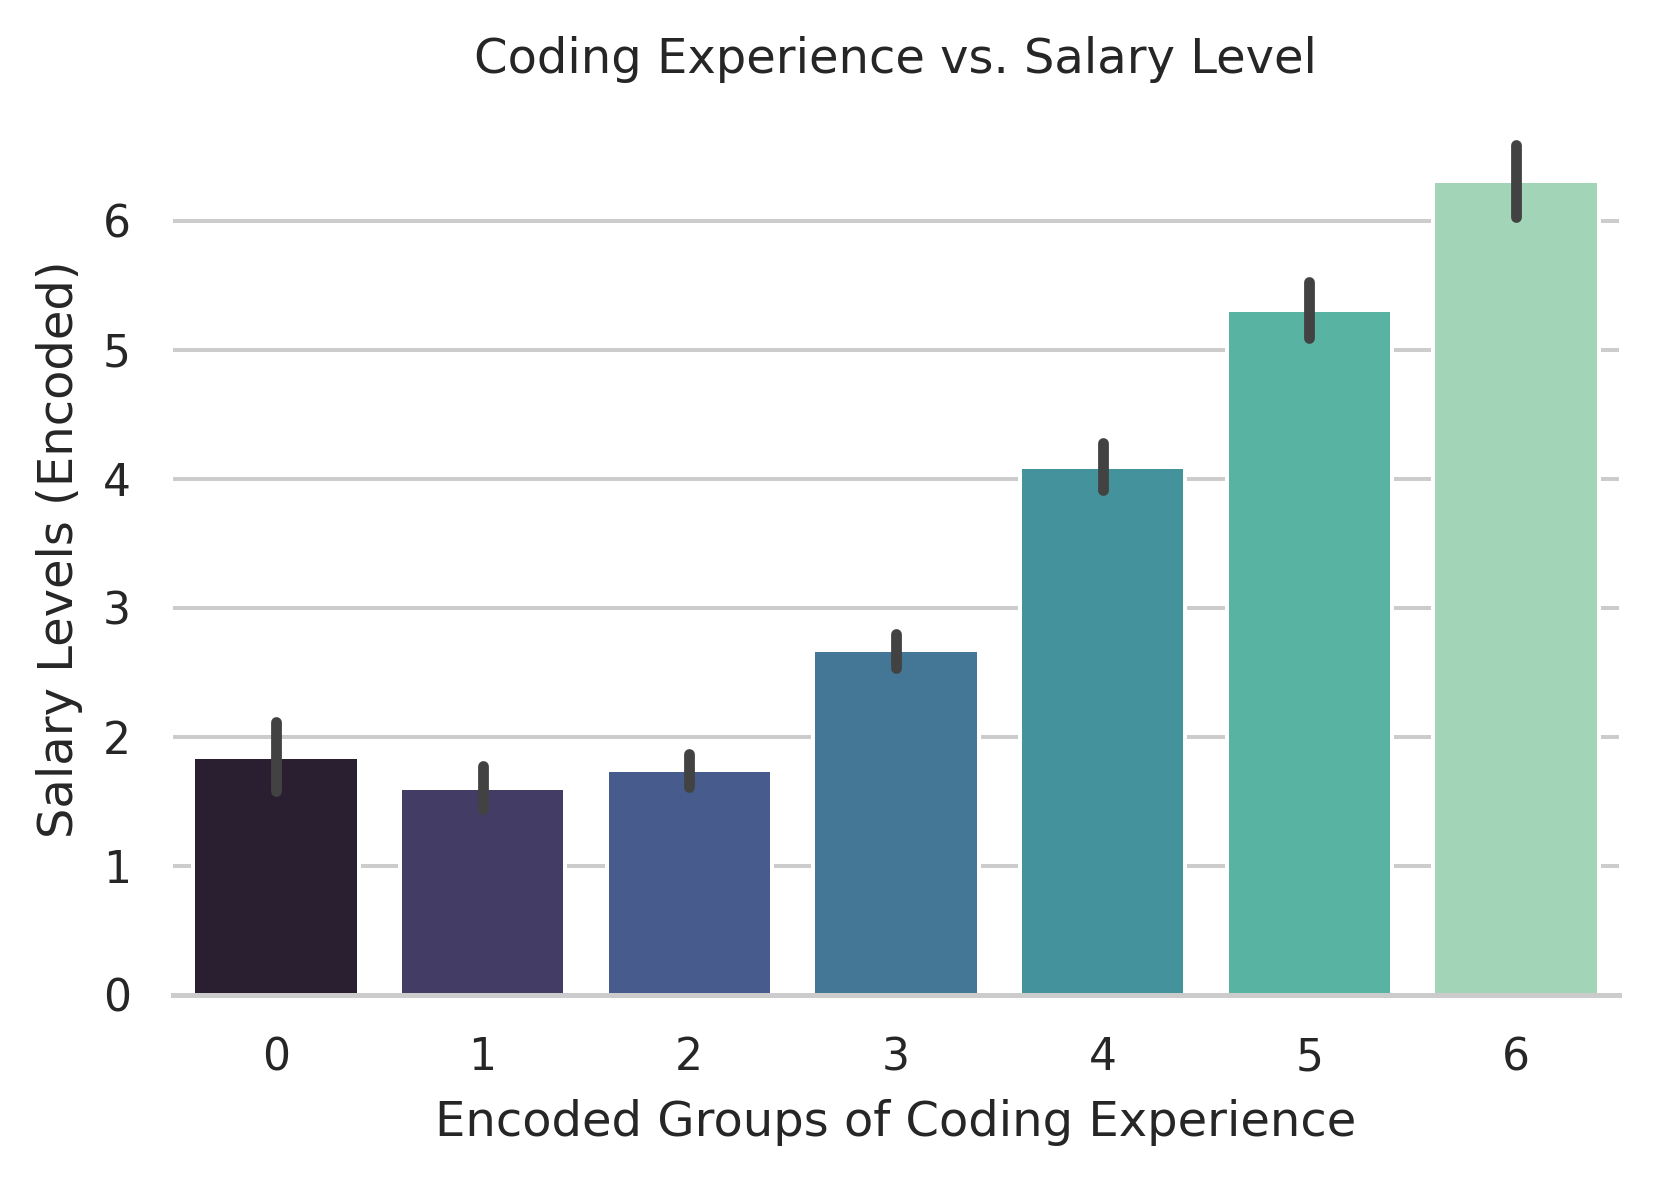

In [ ]:
# Years of coding vs. Salary level
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='Code_years_group', y='Q24_Encoded', data=df, kind='bar', 
                 height=3, aspect=1.5, palette="mako")
ax.set(xlabel='Encoded Groups of Coding Experience', ylabel='Salary Levels (Encoded)', 
       title='Coding Experience vs. Salary Level')
sns.despine(left=True)

The trend shown in the above plot indicates that participants with '5-10 years', '10-20 years', or '20+ years' of coding experience earn much higher salary than those with only a few years of experience. More coding experience leads to higher salary.

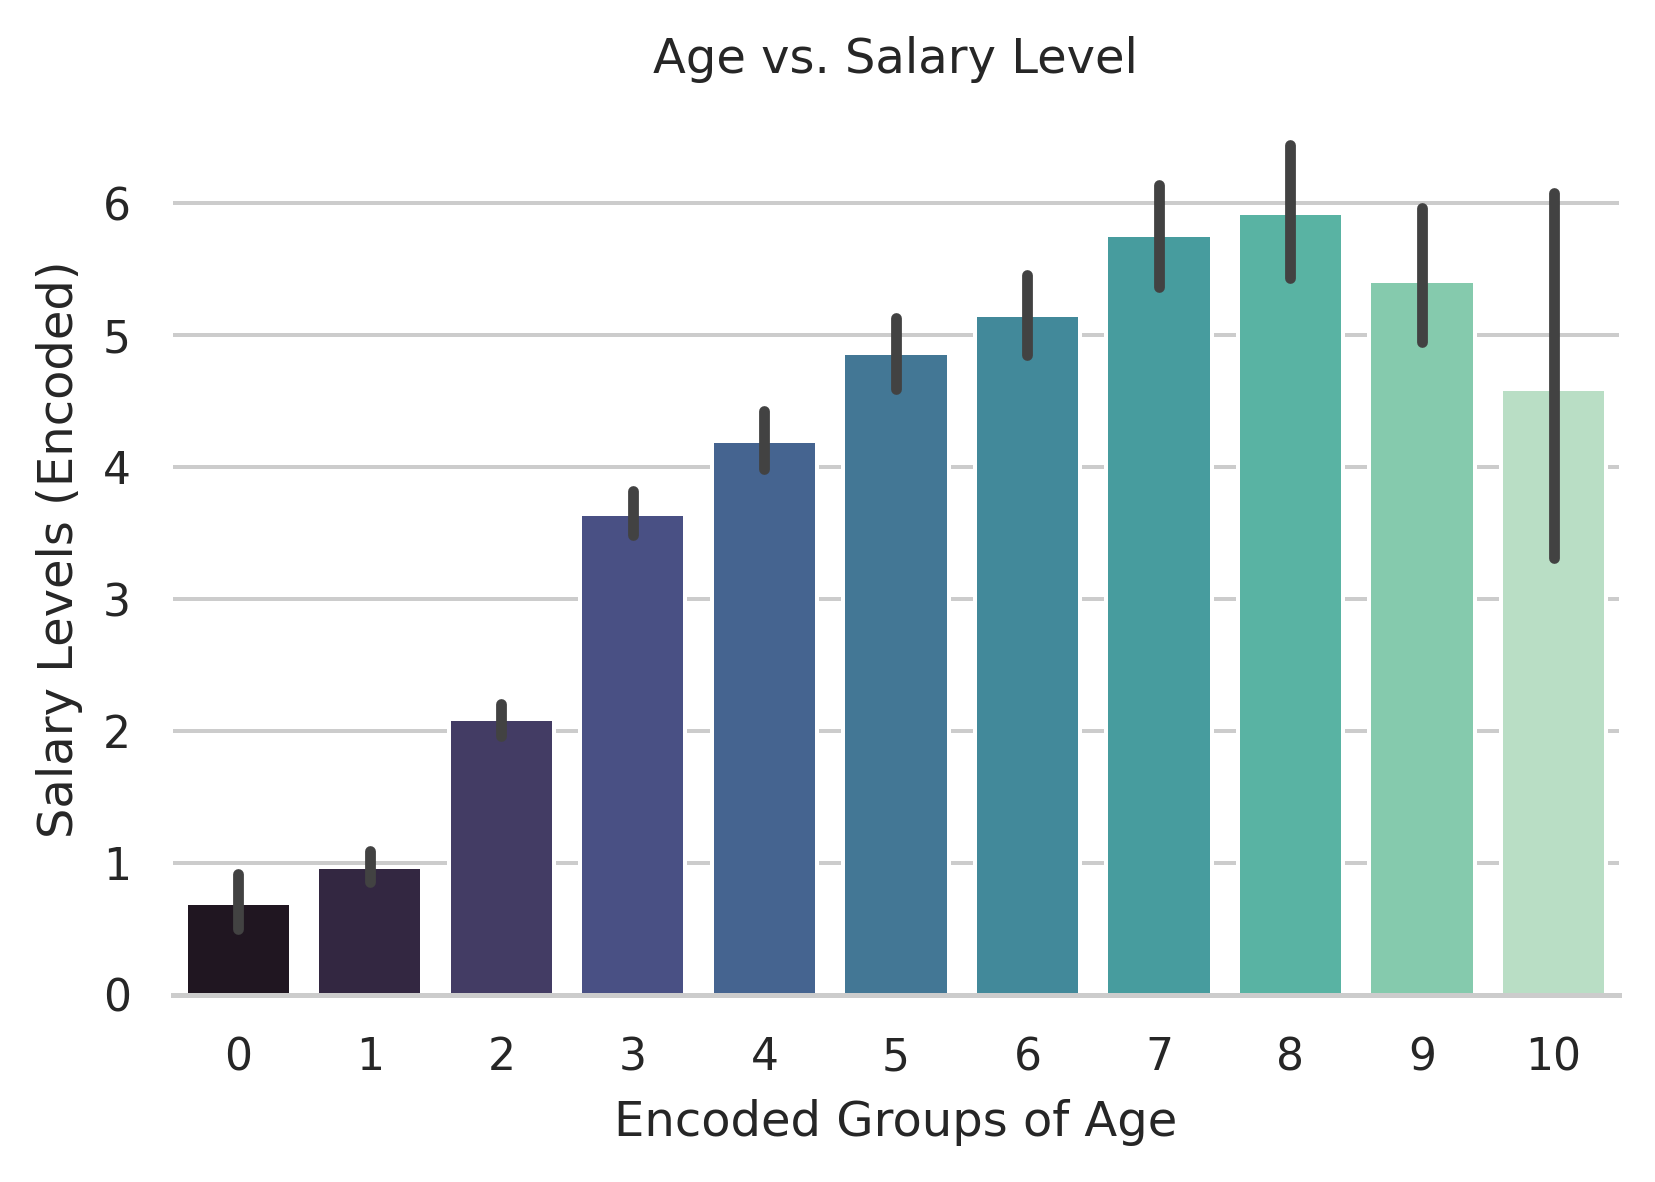

In [ ]:
# Age vs. Salary level
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='Age_group', y='Q24_Encoded', data=df, kind='bar', 
                 height=3, aspect=1.5, palette="mako")
ax.set(xlabel='Encoded Groups of Age', ylabel='Salary Levels (Encoded)', 
       title='Age vs. Salary Level')
sns.despine(left=True)

From the above plot, it is clear that participants in the '55-59', '50-54', and '60-69' age groups reported the highest levels of salary received. The trend in data could be explained by the fact that people in these age groups tend to have more experience and hold higher management positions.

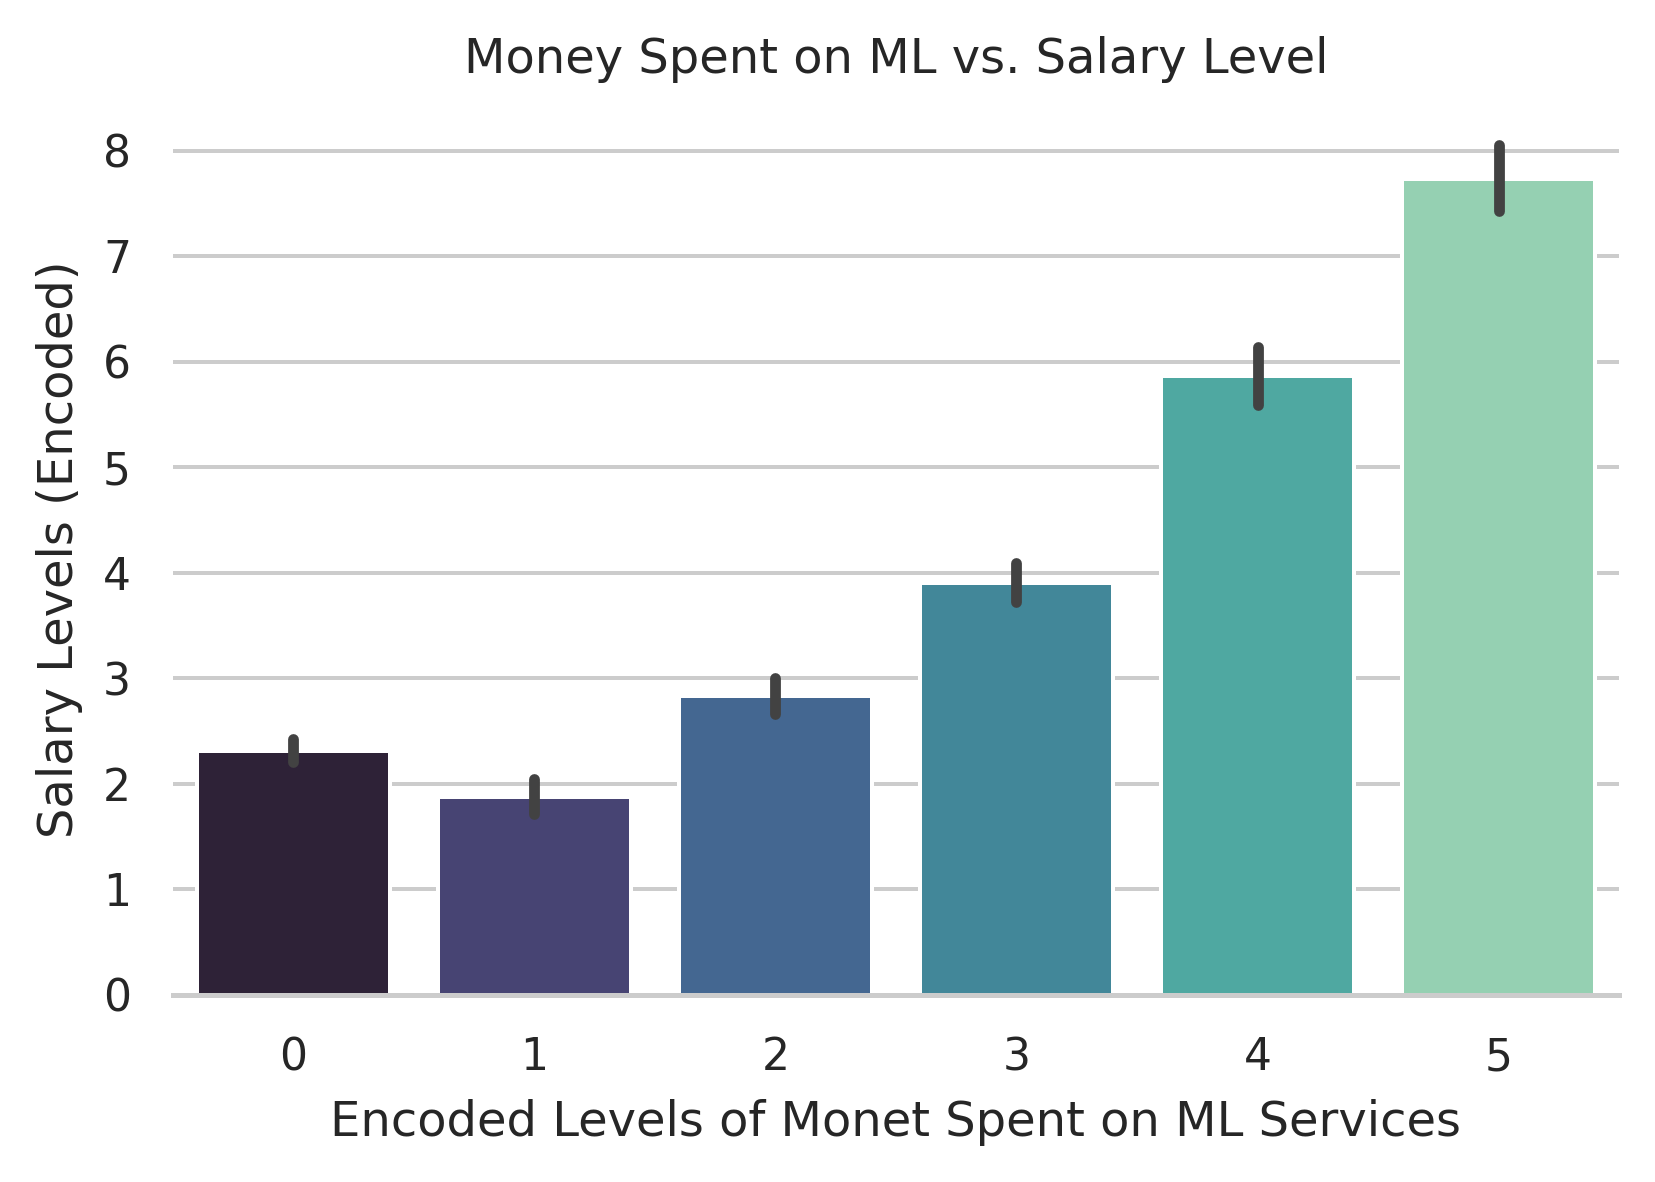

In [ ]:
# Amount of money spent on ML services vs. Salary level
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='ML_spent_level', y='Q24_Encoded', data=df, kind='bar', 
                 height=3, aspect=1.5, palette="mako")
ax.set(xlabel='Encoded Levels of Monet Spent on ML Services', ylabel='Salary Levels (Encoded)', 
       title='Money Spent on ML vs. Salary Level')
sns.despine(left=True)

This plot shows a clear trend that participants who spent more money on machine learning services (at home or at work) tend to receive a higher salary. Those who spent '10,000 - 99,999' or even '100,000 or more' in USD on ML services are among the highest paid participants.

### Feature Selection

In [ ]:
# Separate X and y labels from the dataframe
df_copy = df.copy(deep=True)
X = df_copy.iloc[:,:-1]
y = df_copy.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Use RF classifier to compute feature importance
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance

# Save the features with Gini index > 0
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
top_important_features = importances.sort_values(by='Gini-importance', ascending=False)
top_important_features = top_important_features[top_important_features['Gini-importance'] > 0]

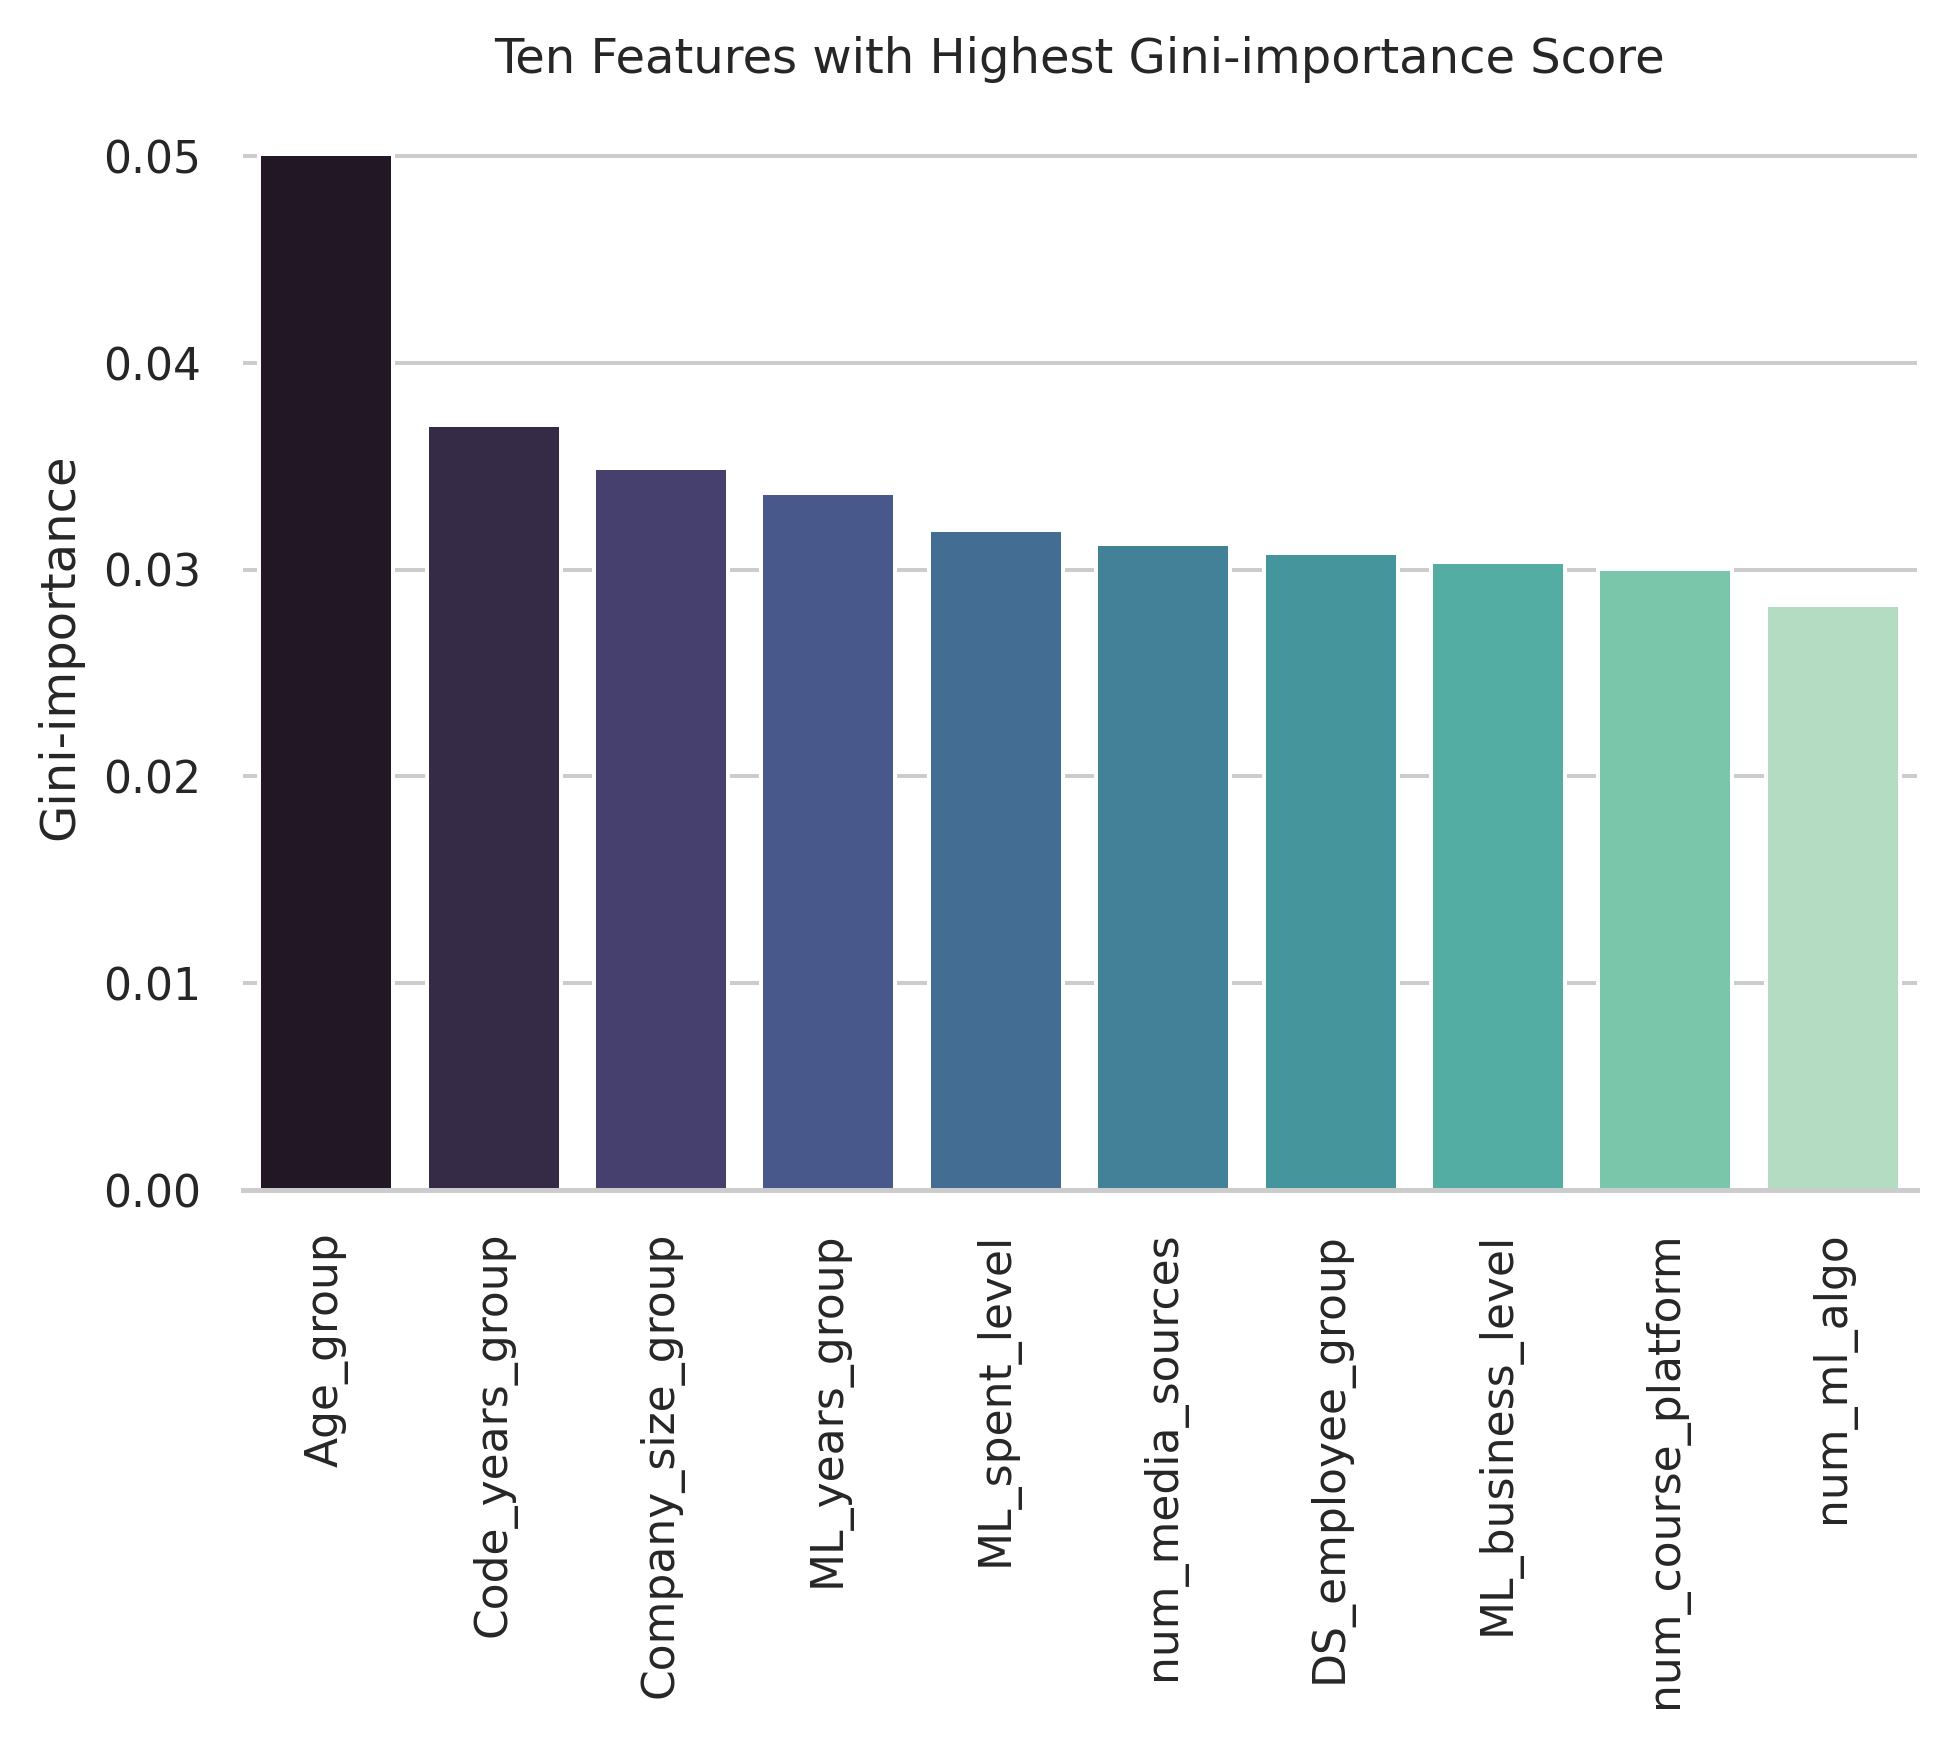

In [ ]:
# Visualization of top 10 important features
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
ax = sns.barplot(x=top_important_features[0:10].index, y='Gini-importance', 
                 data=top_important_features[0:10], palette='mako')
ax.set(title='Ten Features with Highest Gini-importance Score')
plt.xticks(rotation='vertical')
sns.despine(left=True)

In [ ]:
# Select remaining 155 features
X_train = X_train[top_important_features.index]
X_test = X_test[top_important_features.index]

In [ ]:
# Use LassoCV to eliminate irrelevant features (coefficient = 0)
reg = LassoCV(cv=5, random_state=1)
reg.fit(X_train, y_train)
coef = pd.DataFrame(reg.coef_, index = X_train.columns)
coef = coef.sort_values(by=0, ascending=False)
coef.rename(columns={0: 'coefficient'}, inplace=True)
coef = coef[coef.coefficient != 0]

# Select remaining 103 features
X_train = X_train[coef.index]
X_test = X_test[coef.index]

Since the number of remaining features is still relatively high after using Lasso CV, PCA will be implemented next for further feature selection.

In [ ]:
# Use PCA for further feature selection
pca = PCA()
pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
sum_exp_var = np.cumsum(exp_var)
print('Number of PCs needed to explain more than 95% of variance =', np.argmax(sum_exp_var > 0.95) + 1)

Number of PCs needed to explain more than 95% of variance = 28


In [ ]:
# Use PCA with the number of components that can explain 95% variance in data
pca = PCA(n_components=(np.argmax(sum_exp_var > 0.95) + 1))
X_train = pd.DataFrame(pca.fit_transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))

From the PCA results we can see that we only need 28 principal components to explain 95% of variance within the processed data. Thus we will use the remaining features for model implementation.

### Model Implementation and Tuning

Standardization is implemented here because of differences in scales across independent features (some are binary while others have ordinal encoding). In order to better fit the model and predict targets, standardization is necessary.

In [ ]:
# Construct ordinal logistic regression

# Split validation set
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

model = LogisticRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
acc_results = []
proba = []
prob_results = {}

# Standardization of X features
scaler = StandardScaler()
X_t = scaler.fit_transform(X_t)
X_val = scaler.transform(X_val)

for i in range(15):
    y_train_temp = y_t.copy(deep=True)
    if i < 14:
        y_train_temp[y_train_temp <= i] = 0
        y_train_temp[y_train_temp > i] = 1
    if i == 14:
        y_train_temp[y_train_temp < i] = 0
        y_train_temp[y_train_temp == i] = 1
    
    train_results = cross_val_score(model, X_t, y_train_temp, cv=cv, scoring='accuracy')
    acc_results.append(train_results)
    
    model.fit(X_t, y_train_temp)
    # Compute the mean probability of the first class
    proba.append(np.mean(model.predict_proba(X_val)[:, 0]))
    # proba.append(model.predict_proba(X_val)[:, 0])
    
    if i == 0:
        prob_results[i] = proba[i] # probability for first target
    elif i == 14:
        prob_results[i] = np.mean(model.predict_proba(X_val)[:, 1]) # probability for last target
    else:
        prob_results[i] = proba[i] - proba[i-1] # probability of each target in between

# Save accuracies to dataframe
acc_results = pd.DataFrame(acc_results, columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10'])
acc_results

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10
0,0.755459,0.705968,0.705968,0.716157,0.764192,0.755459,0.699708,0.743440,0.727405,0.744898
1,0.724891,0.740902,0.688501,0.723435,0.723435,0.719068,0.693878,0.733236,0.755102,0.746356
2,0.721980,0.721980,0.723435,0.721980,0.736536,0.735080,0.701166,0.741983,0.750729,0.744898
3,0.740902,0.742358,0.745269,0.721980,0.720524,0.739447,0.734694,0.752187,0.763848,0.750729
4,0.767103,0.756914,0.765648,0.754003,0.751092,0.751092,0.781341,0.758017,0.776968,0.760933
5,0.787482,0.768559,0.800582,0.786026,0.765648,0.787482,0.811953,0.794461,0.771137,0.772595
6,0.816594,0.793304,0.809316,0.804949,0.802038,0.804949,0.826531,0.809038,0.790087,0.788630
7,0.831150,0.818049,0.835517,0.825328,0.831150,0.829694,0.846939,0.838192,0.813411,0.813411
8,0.842795,0.842795,0.858806,0.845706,0.850073,0.845706,0.854227,0.836735,0.836735,0.823615
9,0.868996,0.868996,0.871907,0.873362,0.868996,0.866084,0.876093,0.873178,0.860058,0.858601


In [ ]:
# Compute mean and standard deviation of accuracies for each group of classes
acc_results['Average'] = acc_results.mean(axis=1)
acc_results['Standard Deviation'] = acc_results.std(axis=1)
acc_results

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Average,Standard Deviation
0,0.755459,0.705968,0.705968,0.716157,0.764192,0.755459,0.699708,0.743440,0.727405,0.744898,0.731865,0.022592
1,0.724891,0.740902,0.688501,0.723435,0.723435,0.719068,0.693878,0.733236,0.755102,0.746356,0.724880,0.020059
2,0.721980,0.721980,0.723435,0.721980,0.736536,0.735080,0.701166,0.741983,0.750729,0.744898,0.729977,0.013897
3,0.740902,0.742358,0.745269,0.721980,0.720524,0.739447,0.734694,0.752187,0.763848,0.750729,0.741194,0.012589
4,0.767103,0.756914,0.765648,0.754003,0.751092,0.751092,0.781341,0.758017,0.776968,0.760933,0.762311,0.009906
5,0.787482,0.768559,0.800582,0.786026,0.765648,0.787482,0.811953,0.794461,0.771137,0.772595,0.784592,0.014358
6,0.816594,0.793304,0.809316,0.804949,0.802038,0.804949,0.826531,0.809038,0.790087,0.788630,0.804544,0.011255
7,0.831150,0.818049,0.835517,0.825328,0.831150,0.829694,0.846939,0.838192,0.813411,0.813411,0.828284,0.010358
8,0.842795,0.842795,0.858806,0.845706,0.850073,0.845706,0.854227,0.836735,0.836735,0.823615,0.843719,0.009433
9,0.868996,0.868996,0.871907,0.873362,0.868996,0.866084,0.876093,0.873178,0.860058,0.858601,0.868627,0.005389


In [ ]:
# Get average and standard deviations for each fold
for col in results.columns:
    print("Avg acc and std for {}: {}% ({}%)".format(col, round(acc_results[col].mean(axis=0)*100, 3), round(acc_results[col].std(axis=0), 3)))

Avg acc and std for Fold 1: 84.532% (0.097%)
Avg acc and std for Fold 2: 83.823% (0.102%)
Avg acc and std for Fold 3: 84.017% (0.103%)
Avg acc and std for Fold 4: 83.911% (0.102%)
Avg acc and std for Fold 5: 84.017% (0.098%)
Avg acc and std for Fold 6: 84.289% (0.098%)
Avg acc and std for Fold 7: 84.354% (0.106%)
Avg acc and std for Fold 8: 84.519% (0.094%)
Avg acc and std for Fold 9: 83.984% (0.089%)
Avg acc and std for Fold 10: 84.15% (0.097%)


In [ ]:
# Probabilities for each validation sample
# pd.DataFrame(prob_results)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.280670,0.080125,0.121828,0.038213,0.071140,0.064534,0.058838,0.040368,0.035234,0.018539,0.039986,0.038431,0.071054,0.019665,0.017776
1,0.634910,0.100331,0.057271,0.046991,0.027701,0.032139,0.025077,0.013495,0.015777,0.014636,0.017798,0.005747,0.006746,0.000704,0.017776
2,0.853876,0.028227,0.035200,0.020394,0.014923,0.011807,0.009629,0.000102,0.004654,0.003181,0.010892,0.002035,0.003722,0.000587,0.017776
3,0.750672,0.092721,0.031626,0.018619,0.030524,0.019013,0.012665,0.013095,0.004391,0.005701,0.013141,0.003748,0.002487,0.000617,0.017776
4,0.099968,0.102636,0.112477,0.070257,0.070984,0.096862,0.036263,0.082739,0.048922,0.046788,0.092919,0.079457,0.047569,0.007877,0.017776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,0.656189,0.134694,0.079262,0.033518,0.031112,0.011207,0.009027,0.012964,0.000796,0.009100,0.015351,0.001663,0.002255,0.001098,0.017776
1713,0.895848,0.040556,0.013772,0.014359,0.009835,0.005249,0.004783,0.002619,0.002412,0.002146,0.004461,0.001297,0.001359,-0.000004,0.017776
1714,0.697315,0.116878,0.031130,0.027796,0.029097,0.026784,0.013872,0.013387,0.012677,0.006760,0.013950,0.004912,0.003729,0.001030,0.017776
1715,0.548730,0.148718,0.050336,0.017443,0.036955,0.051956,0.016471,0.038037,0.021409,0.011802,0.021041,0.019315,0.013667,0.001145,0.017776


In [ ]:
# Display average predicted probability for each target class
prob_results = pd.DataFrame.from_dict(prob_results, orient='index')
prob_results.rename(columns={0: 'Class Probability'}, inplace=True)
prob_results

,Class Probability
0,0.410284
1,0.103748
2,0.069811
3,0.048695
4,0.050615
5,0.048228
6,0.038024
7,0.033855
8,0.025417
9,0.026283


In [ ]:
# Construct multinomial logistic regression
warnings.filterwarnings("ignore")
LR_model = LogisticRegression(multi_class='multinomial')
# LR_model.fit(X_train, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
train_results = cross_val_score(LR_model, X_train, y_train, cv=cv, scoring='accuracy')

# Accuracy results for each fold
results = {}
for i in range(10):
    score = train_results[i] * 100
    results['Fold ' + str(i+1)] = str(round(score, 3)) + '%'
    # print("Fold "+str(i+1)+" Accuracy: "+str(round(score,3))+"%")

# Save accuracies to dataframe
results = pd.DataFrame.from_dict(results, orient='index')
results.rename(columns={0: 'Train Accuracy'}, inplace=True)
print("Average accuracy and standard deviation for folds: {}% ({}%)".format(round(np.mean(train_results), 3), round(np.std(train_results)*100, 3)))
results

Average accuracy and standard deviation for folds: 0.418% (1.217%)


,Train Accuracy
Fold 1,41.56%
Fold 2,40.745%
Fold 3,43.772%
Fold 4,42.541%
Fold 5,40.909%
Fold 6,39.627%
Fold 7,42.89%
Fold 8,43.007%
Fold 9,40.793%
Fold 10,41.958%


#### Bias-Variance Trade-off with Standardization

In [ ]:
# Function for bias computation
def getBias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.average(np.array(y))
    avg = np.average(y_predict)
    return np.power((avg-y), 2)

In [ ]:
# Compute bias and variance for each c value model
warnings.filterwarnings("ignore")

c_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
bias_list = []
var_list = []
proba_df = pd.DataFrame(np.arange(15), index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
scaler = StandardScaler()
cv = KFold(n_splits=10, shuffle=True, random_state=1)

for C in c_values:
    model = LogisticRegression(multi_class='multinomial', C=C, solver='saga')
    bias, var = [], []
    for train_idx, test_idx in cv.split(X_train):
        X_train2, X_test2 = X_train.values[train_idx], X_train.values[test_idx]
        y_train2, y_test2 = y_train.values[train_idx], y_train.values[test_idx]

        # Standardization of X features
        X_train2 = scaler.fit_transform(X_train2)
        X_test2 = scaler.transform(X_test2)

        model.fit(X_train2, y_train2)

        predictions = model.predict(X_test2)
        proba = model.predict_proba(X_test2)

        bias.append(getBias(predictions, y_train2))
        var.append(np.var(predictions))

    # Save bias and variance for each model
    var_list.append(np.average(var))
    bias_list.append(np.average(bias))

    # Save probabilities for each model
    proba_ = pd.DataFrame(pd.DataFrame(proba).mean(), columns=[str(C)], index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
    proba_df = pd.concat([proba_df, proba_], axis=1)

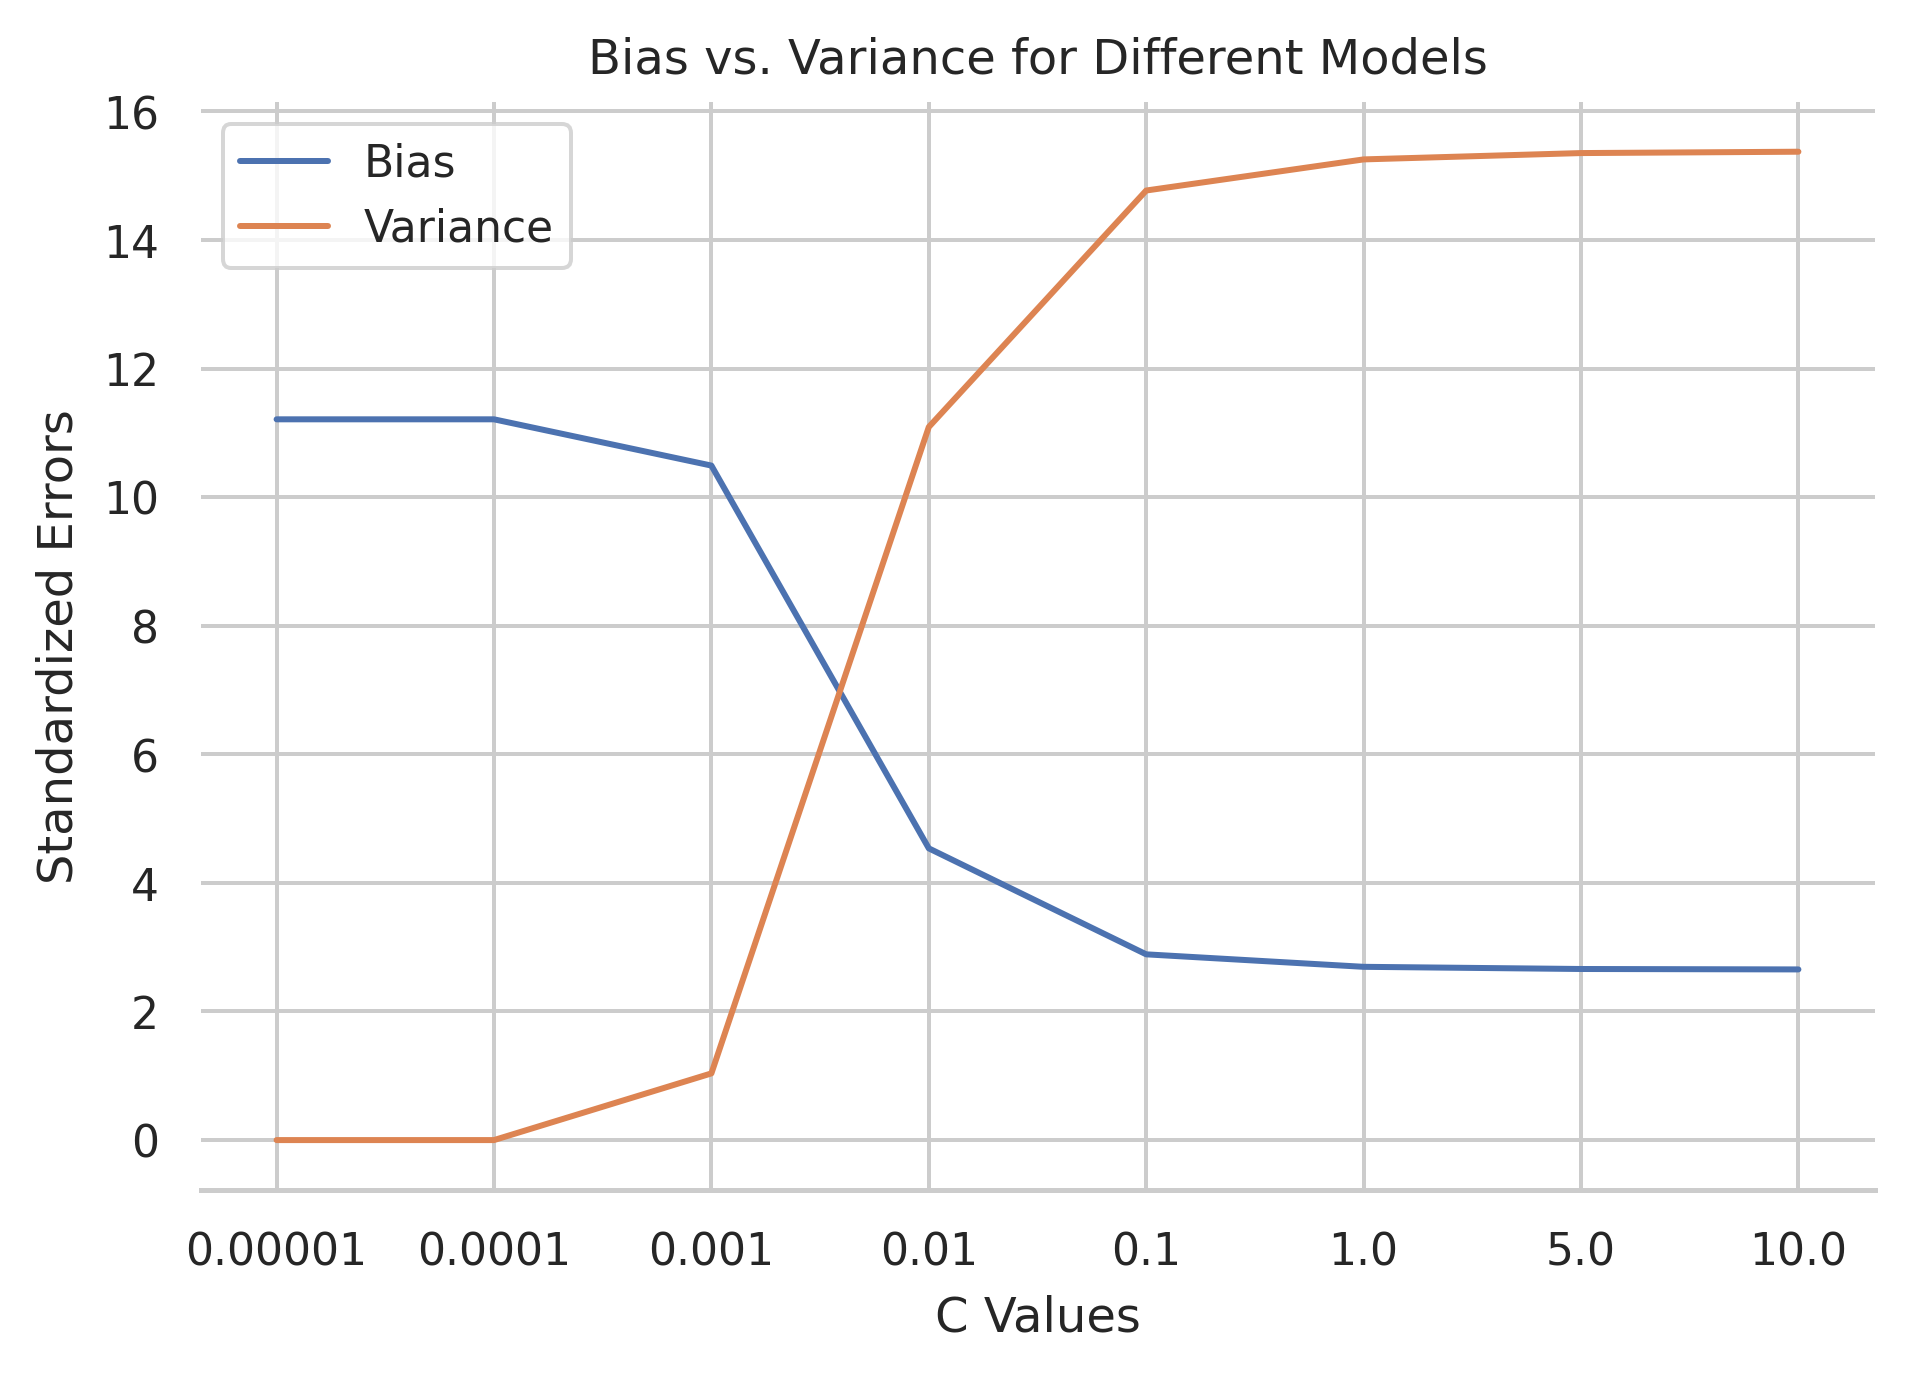

In [ ]:
# Bias vs. Variance plot
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
plt.plot(bias_list, label='Bias', alpha=1)
plt.plot(var_list, label='Variance', alpha=1)
plt.legend()
plt.title('Bias vs. Variance for Different Models')
plt.xlabel('C Values')
plt.xticks(np.arange(8), ('0.00001', '0.0001', '0.001', '0.01', '0.1', '1.0', '5.0', '10.0'))
plt.ylabel('Standardized Errors')
sns.despine(left=True)

Bias is the squared error between average prediction of the model and true target, while variance is the variability of the predictions.

High bias indicates underfitting (left side of plot, heavy regularization, model is over simplified), while high variance indicates overfitting (right side of plot, little regularization, model fits in noise within the train data, not generalizable).

Smaller C values leads to simpler model that is prone to underfitting, (high bias, low variance) while larger C values leads to more complicated model that is easy to overfit (low bias, high variance). By treating each c value of hyperparameter as a new model, the above bias-variance trade-off plot is constructed.

From this plot we can see that the balance of bias and variance occurs between c values of 0.001 and 0.01. Thus, we will be using this range of c values for the tuning part.

In [ ]:
# Display probabilities for all models
proba_df.drop(columns=0, inplace=True)
proba_df

,1e-05,0.0001,0.001,0.01,0.1,1.0,5.0,10.0
0,0.412299,0.409431,0.399730,0.393054,0.391545,0.391348,0.391330,0.391328
1,0.104379,0.104680,0.104884,0.103497,0.102833,0.102736,0.102727,0.102726
2,0.069554,0.069863,0.070649,0.070350,0.069956,0.069888,0.069882,0.069881
3,0.049349,0.049591,0.050385,0.050728,0.050655,0.050635,0.050633,0.050633
4,0.051294,0.051570,0.052565,0.053138,0.053070,0.053045,0.053042,0.053042
5,0.047796,0.048052,0.048991,0.049702,0.049807,0.049817,0.049818,0.049819
6,0.037693,0.037907,0.038786,0.039751,0.040028,0.040066,0.040070,0.040071
7,0.034193,0.034369,0.035039,0.035619,0.035773,0.035800,0.035803,0.035803
8,0.024864,0.024991,0.025515,0.026233,0.026555,0.026605,0.026610,0.026611
9,0.026289,0.026423,0.026951,0.027472,0.027597,0.027614,0.027615,0.027616


#### Hyperparameter Tuning using Grid Search

Hyperparameters for logistic regression include:
- regularization / penalty (L1, L2, Elastic net)
- C: Inverse of regularization strength, smaller values specify stronger regularization
- solver types

However, since all solvers would produce the same results for convex functions (the cross-entropy cost function), solver type will not be considered for tuning in this part.

Since the 'saga' solver can handle large dataset with multiclass targets, and it supports L1, L2, and elastic net penalties, we will be using this solver for the tuning part.

F1 score is used in the grid search because of the presence of class imbalance within the multiclass dataset. Simply looking at accuracy might not be sufficient in this case because of different class sizes. In order to obtain a best model, evaluating F1 score is a good way to balance precision and recall.

Here 'f1_weighted' is used because it calculates metrics for each label, and find their average weighted by support (the number of true instances for each label). This accounts for label imbalance in the data.

In [ ]:
# Use pipeline and GridSearchCV to find optimal hyperparameters
pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(multi_class='multinomial'))])

param_grid = {'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'], 'lr__solver': ['saga'],
              'lr__C': np.arange(0.001, 0.01, 0.001)}

X_train_grid = X_train.copy(deep=True)
grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True, scoring='f1_weighted')
grid_search.fit(X_train_grid, y_train)

# Save results
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
best_model =  grid_search.best_estimator_
results = pd.DataFrame(grid_search.cv_results_)

print("Best parameters with scaling grid: {}".format(best_parameters))
print("Best cross-validation F1 score with scaling grid: {:.2f}".format(best_score))

Best parameters with scaling grid: {'lr__C': 0.001, 'lr__penalty': 'none', 'lr__solver': 'saga'}
Best cross-validation F1 score with scaling grid: 0.29


#### Testing using Grid Search Results

In [ ]:
# Standardization of X features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:
# Get salary levels from salary buckets
salary_level = ['$0-9,999', '$10,000-19,999', '$20,000-29,999','$30,000-39,999','$40,000-49,999',
                '$50,000-59,999','$60,000-69,999','$70,000-79,999','$80,000-89,999','$90,000-99,999',
                '$100,000-124,999','$125,000-149,999','$150,000-199,999','$200,000-249,999','> $250,000']

In [ ]:
# Fit best model from grid search
best_model.fit(X_train, y_train)

# Evaluation using train set
y_pred_train = best_model.predict(X_train)
print('Accuracy using train set:', accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, target_names=salary_level))

# Evaluation using test set
y_pred = best_model.predict(X_test)
print('Accuracy using test set:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=salary_level))

Accuracy using train set: 0.42514272398928116
                  precision    recall  f1-score   support

        $0-9,999       0.48      0.96      0.64      3542
  $10,000-19,999       0.15      0.02      0.03       898
  $20,000-29,999       0.00      0.00      0.00       583
  $30,000-39,999       0.00      0.00      0.00       422
  $40,000-49,999       0.15      0.02      0.03       446
  $50,000-59,999       0.16      0.02      0.04       417
  $60,000-69,999       0.00      0.00      0.00       321
  $70,000-79,999       0.00      0.00      0.00       294
  $80,000-89,999       0.00      0.00      0.00       210
  $90,000-99,999       0.18      0.01      0.02       225
$100,000-124,999       0.17      0.26      0.20       470
$125,000-149,999       0.15      0.05      0.07       258
$150,000-199,999       0.19      0.26      0.22       276
$200,000-249,999       0.17      0.05      0.08        95
      > $250,000       0.19      0.07      0.10       126

        accuracy        

#### Plotting Results and Discussion

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

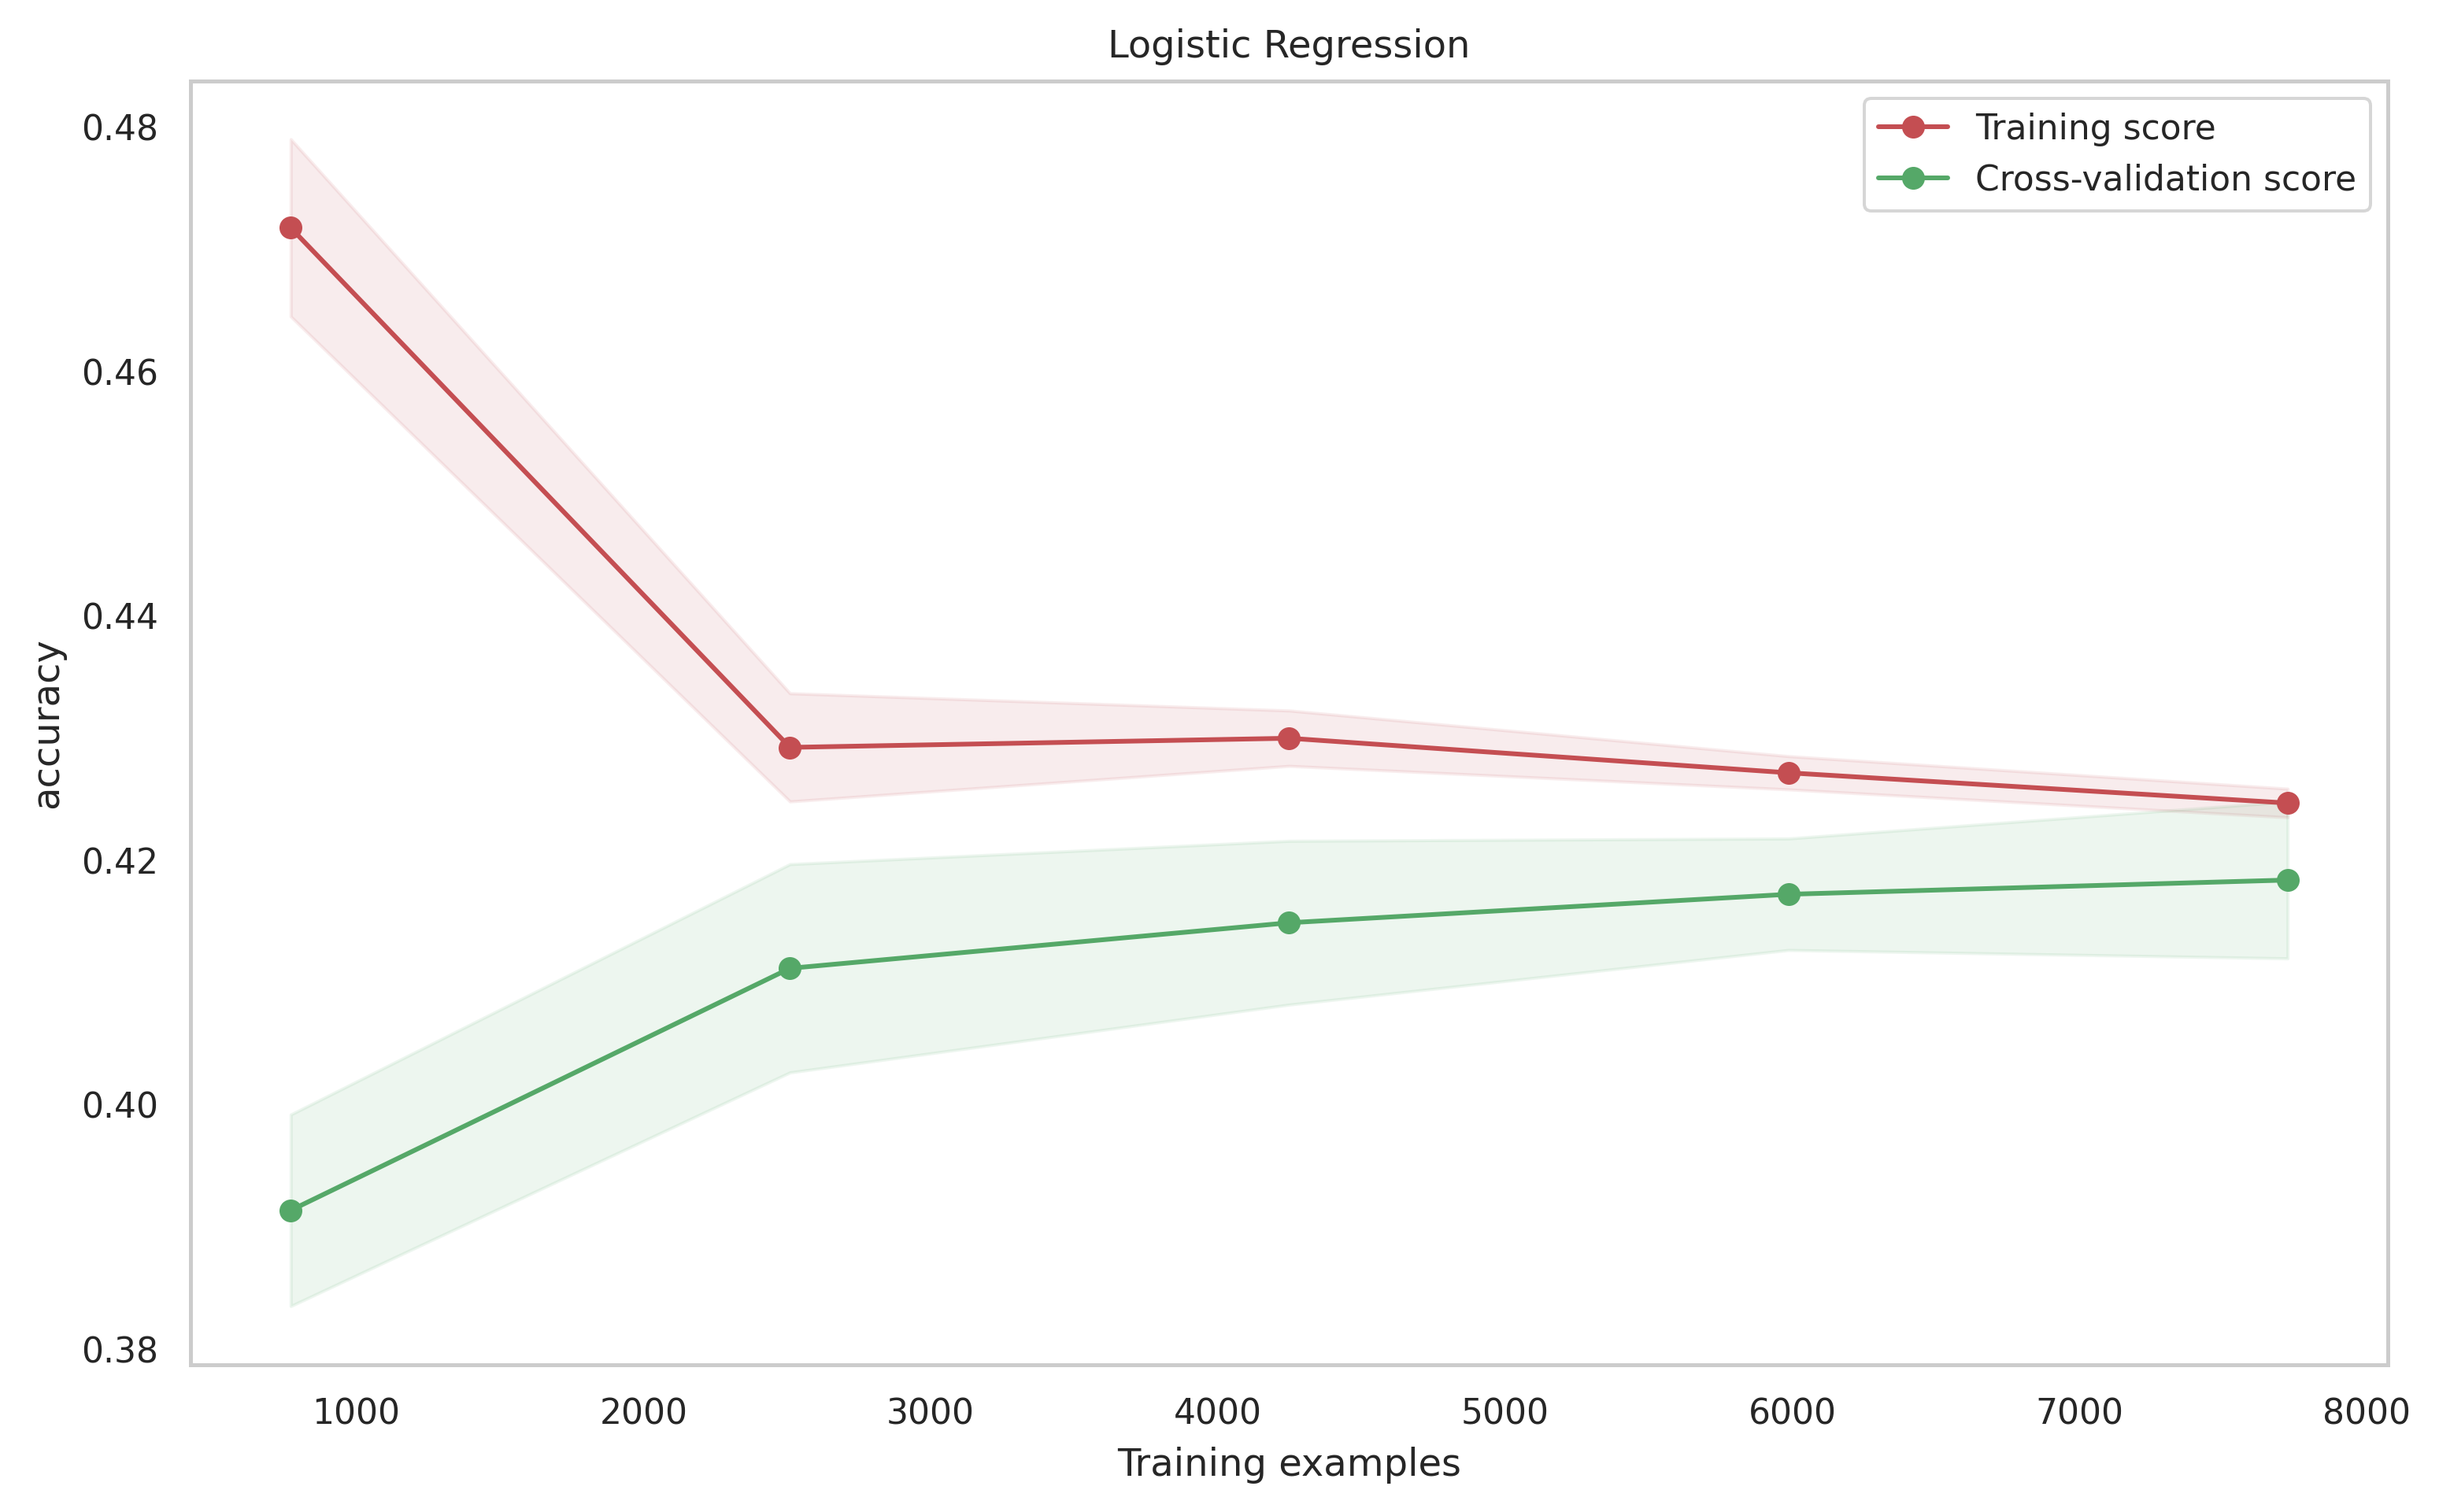

In [ ]:
plot_learning_curve(best_model,'Logistic Regression', X_train, y_train, cv=10)

From the learning curves shown above, we can see that when training example is less than 2500. the model tends to overfit due to the insufficiency of samples. Both training and validation accuracies plateau after train size exceeds 6000.

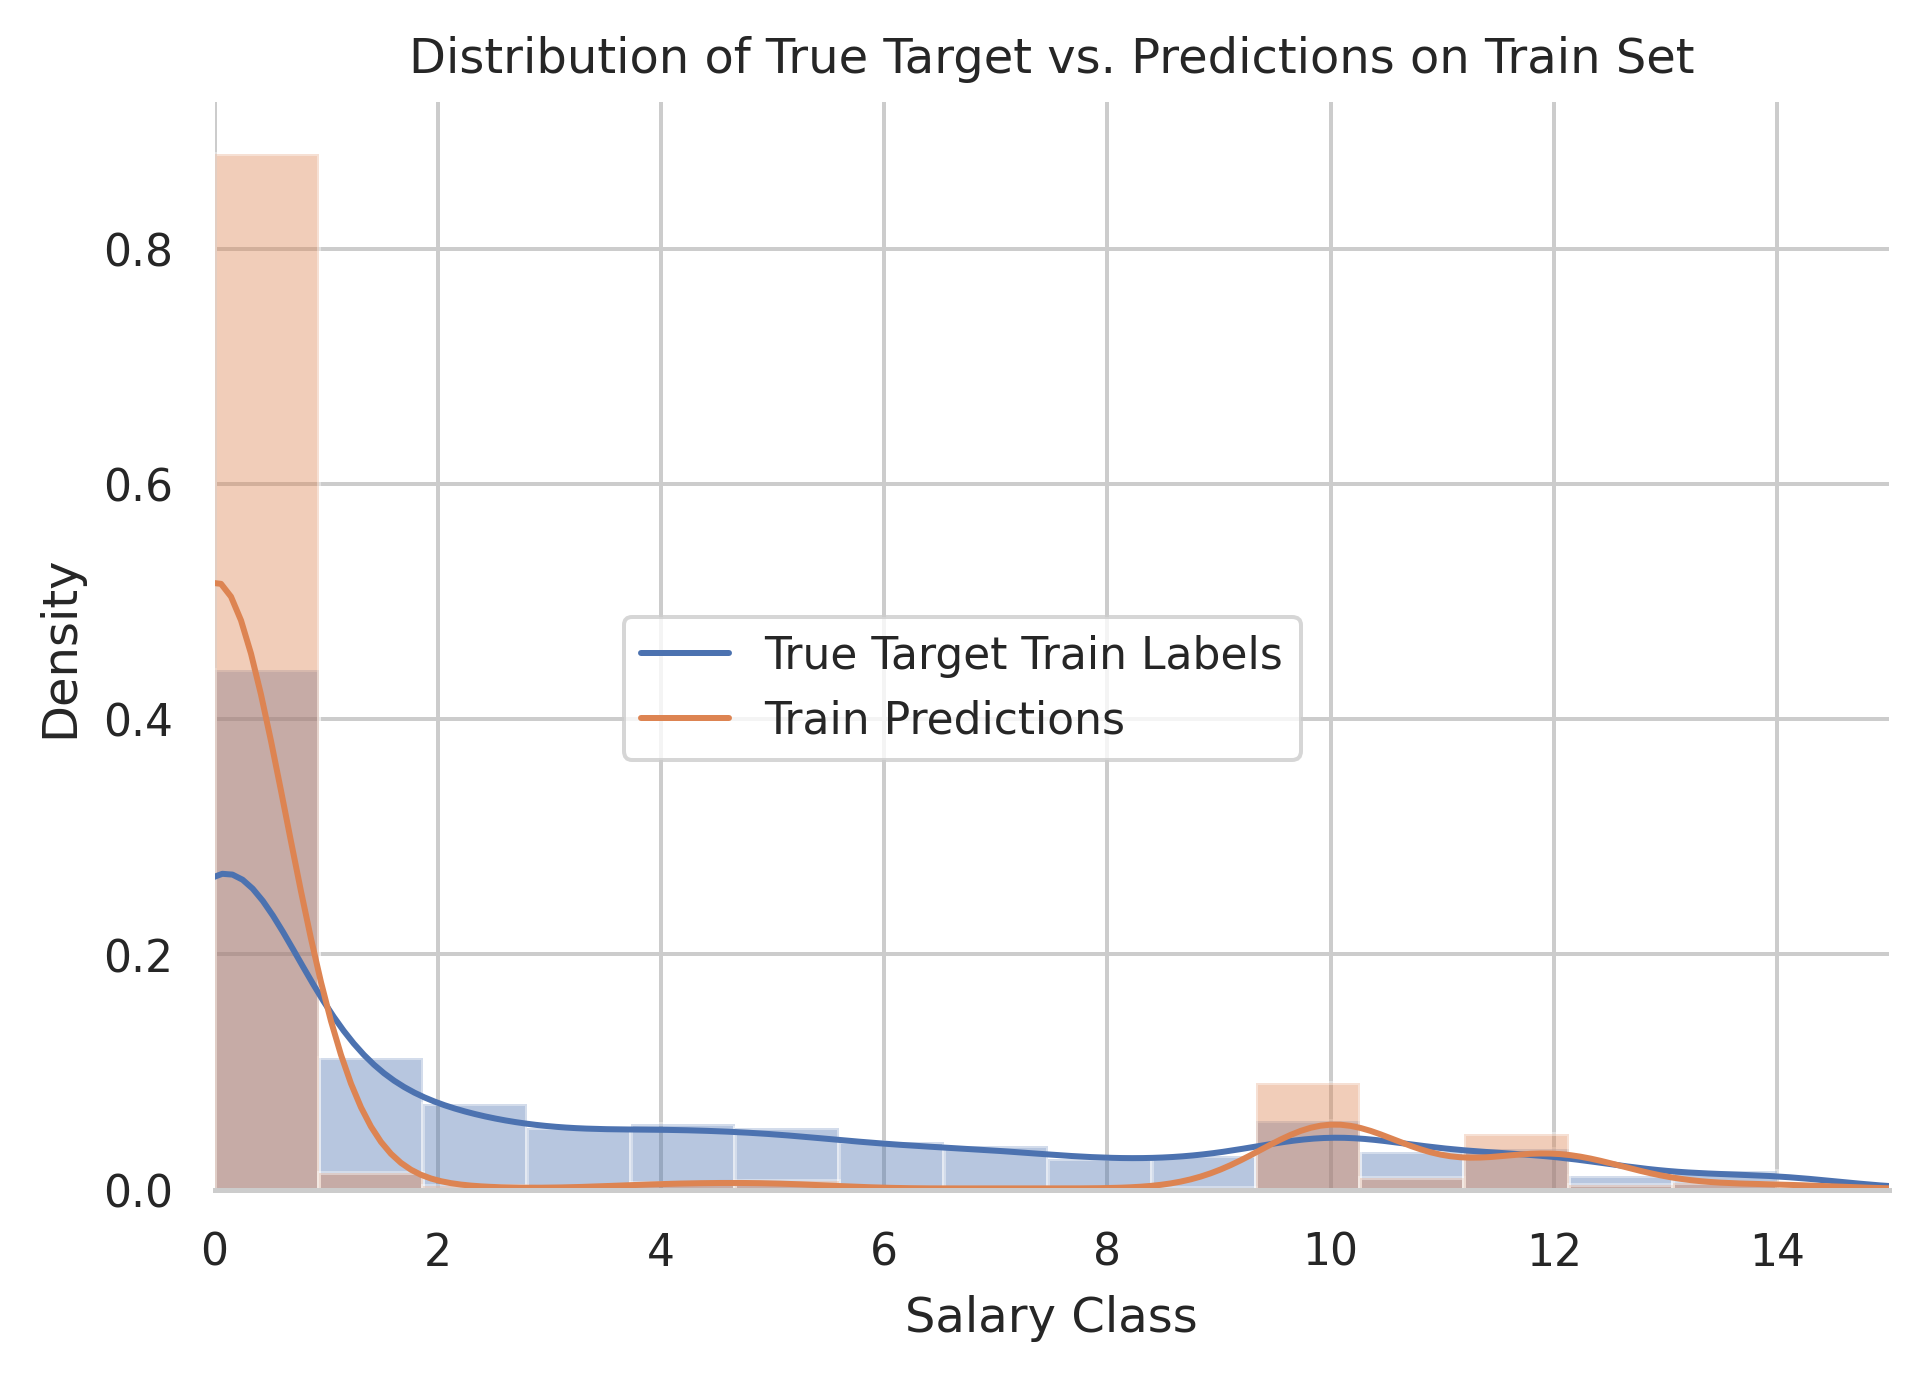

In [ ]:
# Plot distribution of true target vs. prediction on train set
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
fig, ax = plt.subplots()
for a in [y_train, y_pred_train]:
    sns.distplot(a, bins=15, ax=ax)
fig.legend(labels=['True Target Train Labels', 'Train Predictions'], loc='center')
plt.xlim(0, 15)
ax.set(title='Distribution of True Target vs. Predictions on Train Set', xlabel='Salary Class')
sns.despine(left=True)

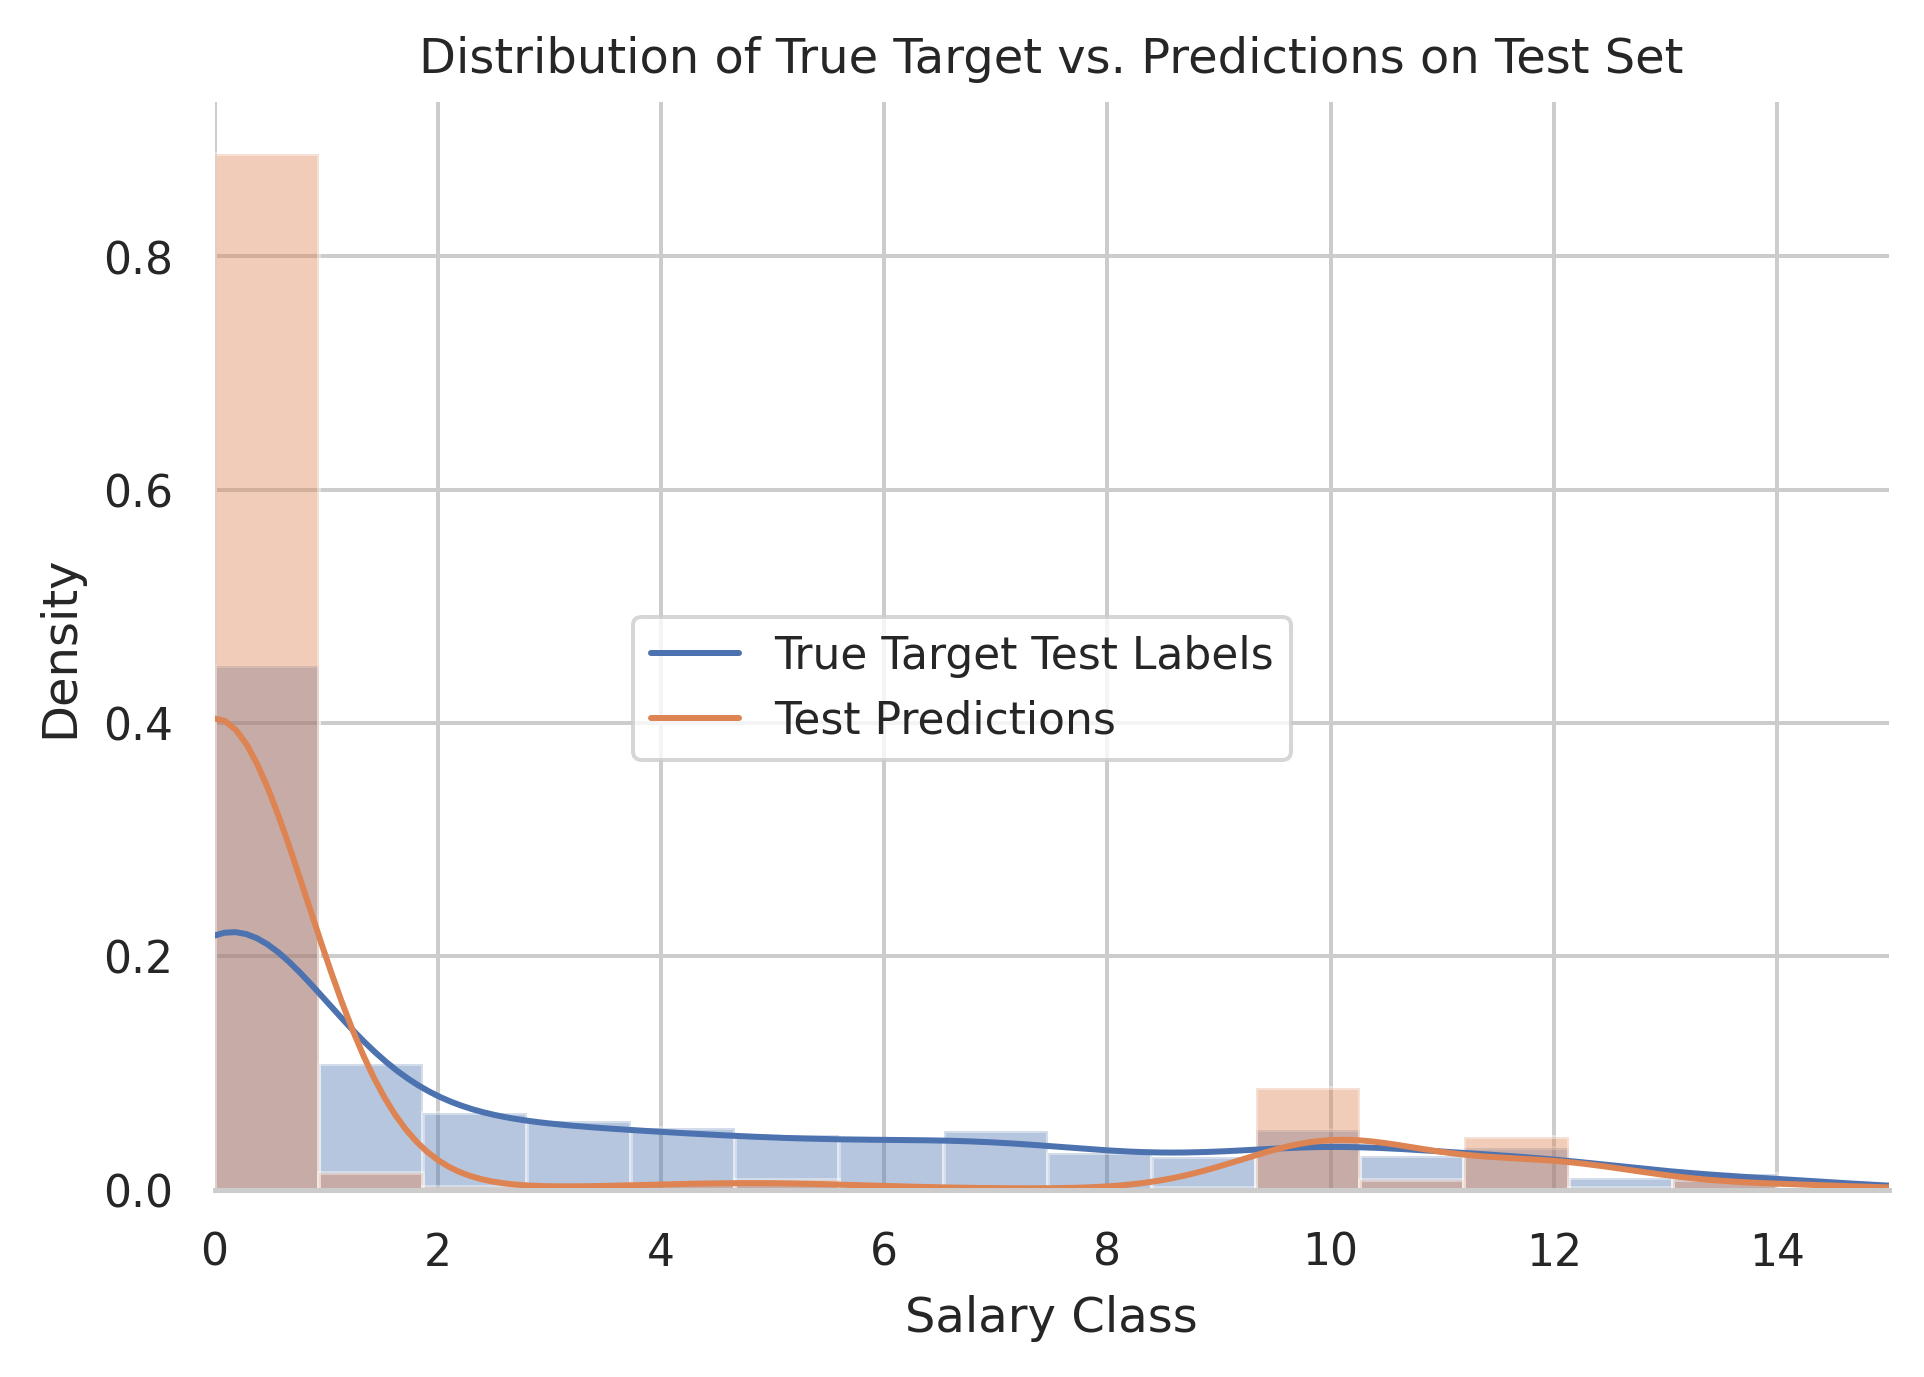

In [ ]:
# Plot distribution of true target vs. prediction on test set
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 360
fig, ax = plt.subplots()
for a in [y_test, y_pred]:
    sns.distplot(a, bins=15, ax=ax)
fig.legend(labels=['True Target Test Labels', 'Test Predictions'], loc='center')
plt.xlim(0, 15)
ax.set(title='Distribution of True Target vs. Predictions on Test Set', xlabel='Salary Class')
sns.despine(left=True)

From the learning curves and the results from the last part (training accuracy = 0.425, testing accuracy = 0.420), it is safe to say that the model only has minor overfitting issues (train accuracy > test accuracy).

Main issues that led to the low training and testing accuracies include the following:

- Information might be lost during feature engineering and encoding. Multiple choice questions are combined into a summation, while nominal features are one-hot encoded. Retaining more features (multiple choice parts as binary values) might be a way to save information, but the curse of dimensionality would be dire.

- The imbalance issue is apparent in the above distribution plots as we can see that most of the participants can be classified into the first salary level. The first target class has much more supports in both training and testing reports.

- It is also possible that the multi-class logistic regression model did not capture the relationships within this data well. Ordinal logistic regression might do a better job.